<a href="https://colab.research.google.com/github/aranya-chatterjee/CryptoPredictor/blob/main/CryptoPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install yfinance
! pip install joblib
! pip install streamlit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from datetime import datetime, timedelta
import joblib
import streamlit as st
import os

In [ ]:
def quick_data_load():
    data = yf.download('BTC-USD', period='1y')
    data = data.reset_index()
    # The columns after reset_index() have a MultiIndex. Flatten it first.
    # Using list comprehension with '_'.join to handle potential tuples in MultiIndex
    data.columns = ['_'.join(str(c) for c in col if str(c)).strip() if isinstance(col, tuple) else str(col).strip() for col in data.columns]

    print("Columns after flattening MultiIndex:", data.columns)

    # Now, rename the flattened columns to the desired simpler names using .rename()
    # Based on the flattened column names from the output: 'Date', 'Close_BTC-USD', 'High_BTC-USD', 'Low_BTC-USD', 'Open_BTC-USD', 'Volume_BTC-USD'
    # Let's rename them to lowercase and simpler names.
    rename_dict = {
        'Date': 'date',
        'Close_BTC-USD': 'close',
        'High_BTC-USD': 'high',
        'Low_BTC-USD': 'low',
        'Open_BTC-USD': 'open',
        'Volume_BTC-USD': 'volume'
    }

    # Use .rename() to rename columns
    data = data.rename(columns=rename_dict)

    # Convert date column to datetime objects
    data['date'] = pd.to_datetime(data['date'])

    # Reorder columns to a more standard order if needed (optional, but good practice)
    data = data[['date', 'open', 'high', 'low', 'close', 'volume']]


    # Add simple features (ensure these features can be calculated with the available columns)
    # Check if 'close' column exists before calculating price_change
    if 'close' in data.columns:
      data['price_change'] = data['close'].pct_change()
      data['sma_7'] = data['close'].rolling(7).mean()
      data['sma_30'] = data['close'].rolling(30).mean()


    # Clean data
    data = data.dropna()

    print(f"✅ Loaded {len(data)} days of Bitcoin data")
    print(f"📊 Columns: {list(data.columns)}")
    # Check if 'close' column exists before printing latest price
    if 'close' in data.columns and not data['close'].empty:
      print(f"💰 Latest price: ${data['close'].iloc[-1]:.2f}")
    else:
        print("⚠️ Cannot display latest price: 'close' column not available or is empty.")


    return data

# Run it!
btc_data = quick_data_load()
btc_data.to_csv('bitcoin_formatted.csv', index=False)

[*********************100%***********************]  1 of 1 completed

Columns after flattening MultiIndex: Index(['Date', 'Close_BTC-USD', 'High_BTC-USD', 'Low_BTC-USD', 'Open_BTC-USD',
       'Volume_BTC-USD'],
      dtype='object')
✅ Loaded 337 days of Bitcoin data
📊 Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'price_change', 'sma_7', 'sma_30']
💰 Latest price: $103138.74


In [ ]:
def create_data_directory():
    """Create directory structure for data"""
    os.makedirs('data/raw', exist_ok=True)
    os.makedirs('data/processed', exist_ok=True)
    print("✅ Data directories created")

def load_crypto_data(symbol='BTC-USD', period='2y', save_raw=True):
    """
    Load cryptocurrency data from Yahoo Finance
    """
    print(f"📥 Loading {symbol} data for {period}...")

    try:
        # Download data
        data = yf.download(symbol, period=period, interval='1d')

        if data.empty:
            print(f"❌ No data found for {symbol}")
            return None

        # Reset index to make Date a column
        data = data.reset_index()

        # Rename columns for consistency - Correcting to 6 column names
        # The columns after reset_index() are likely 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'
        data.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

        # Convert date to datetime - This line will cause an error if 'date' column doesn't exist after renaming
        # data['date'] = pd.to_datetime(data['date']) # Removing this line for now

        # Sort by date (oldest to newest) - This will use the index if 'date' column is not set
        data = data.sort_values(by=data.index).reset_index(drop=True)


        # Save raw data
        if save_raw:
            filename = f"data/raw/{symbol.replace('-', '_')}_raw.csv"
            data.to_csv(filename, index=False)
            print(f"💾 Raw data saved: {filename}")

        print(f"✅ Successfully loaded {len(data)} days of {symbol} data")
        return data

    except Exception as e:
        print(f"❌ Error loading {symbol}: {e}")
        return None

def clean_and_validate_data(df, symbol):
    """
    Clean and validate the dataset
    """
    print(f"🧹 Cleaning {symbol} data...")

    # Create a copy
    clean_df = df.copy()

    # Check for missing values
    missing_before = clean_df.isnull().sum().sum()
    print(f"   Missing values before cleaning: {missing_before}")

    # Fill missing values (forward fill for prices, 0 for volume)
    clean_df['volume'] = clean_df['volume'].fillna(0)
    clean_df = clean_df.ffill()  # Forward fill price data

    # Remove any remaining rows with NaN values
    clean_df = clean_df.dropna()

    # Validate data types
    # Assuming 'date' is the index or a column named 'date' exists
    if 'date' in clean_df.columns:
      clean_df['date'] = pd.to_datetime(clean_df['date'])
    elif isinstance(clean_df.index, pd.DatetimeIndex):
        clean_df = clean_df.reset_index()
        clean_df.rename(columns={'index': 'date'}, inplace=True)
        clean_df['date'] = pd.to_datetime(clean_df['date'])
    else:
        print("Warning: 'date' column not found and index is not DatetimeIndex.")


    numeric_columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
    for col in numeric_columns:
        if col in clean_df.columns:
            clean_df[col] = pd.to_numeric(clean_df[col], errors='coerce')

    # Remove duplicates
    if 'date' in clean_df.columns:
        clean_df = clean_df.drop_duplicates(subset=['date'])
    else:
        print("Warning: Cannot check for duplicates without a 'date' column.")


    # Ensure chronological order
    if 'date' in clean_df.columns:
        clean_df = clean_df.sort_values('date').reset_index(drop=True)
    else:
        print("Warning: Cannot sort by date without a 'date' column.")


    # Data validation checks
    print(f"   Rows after cleaning: {len(clean_df)}")
    if 'date' in clean_df.columns:
      print(f"   Date range: {clean_df['date'].min().date()} to {clean_df['date'].max().date()}")
    print(f"   Missing values after cleaning: {clean_df.isnull().sum().sum()}")

    return clean_df

def add_technical_features(df):
    """
    Add technical indicators and features
    """
    print("📊 Adding technical features...")

    feature_df = df.copy()

    # Price-based features
    if 'close' in feature_df.columns:
        feature_df['price_change'] = feature_df['close'].pct_change()
    if 'high' in feature_df.columns and 'low' in feature_df.columns:
        feature_df['high_low_ratio'] = feature_df['high'] / feature_df['low']
    if 'open' in feature_df.columns and 'close' in feature_df.columns:
        feature_df['open_close_ratio'] = feature_df['open'] / feature_df['close']

    # Moving averages
    if 'close' in feature_df.columns:
        feature_df['sma_7'] = feature_df['close'].rolling(window=7).mean()
        feature_df['sma_30'] = feature_df['close'].rolling(window=30).mean()
        feature_df['sma_90'] = feature_df['close'].rolling(window=90).mean()

    # Moving average ratios
    if 'close' in feature_df.columns and 'sma_7' in feature_df.columns:
        feature_df['sma_7_ratio'] = feature_df['close'] / feature_df['sma_7']
    if 'close' in feature_df.columns and 'sma_30' in feature_df.columns:
        feature_df['sma_30_ratio'] = feature_df['close'] / feature_df['sma_30']

    # Volatility
    if 'close' in feature_df.columns:
        feature_df['volatility_7'] = feature_df['close'].pct_change().rolling(window=7).std()
        feature_df['volatility_30'] = feature_df['close'].pct_change().rolling(window=30).std()

    # Volume indicators
    if 'volume' in feature_df.columns:
        feature_df['volume_sma'] = feature_df['volume'].rolling(window=10).mean()
    if 'volume' in feature_df.columns and 'volume_sma' in feature_df.columns:
        feature_df['volume_ratio'] = feature_df['volume'] / feature_df['volume_sma']

    # RSI (Relative Strength Index)
    if 'close' in feature_df.columns:
        delta = feature_df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        # Avoid division by zero
        rs = gain / loss.replace(0, np.nan)
        feature_df['rsi'] = 100 - (100 / (1 + rs))


    # MACD
    if 'close' in feature_df.columns:
        exp1 = feature_df['close'].ewm(span=12).mean()
        exp2 = feature_df['close'].ewm(span=26).mean()
        feature_df['macd'] = exp1 - exp2
    if 'macd' in feature_df.columns:
        feature_df['macd_signal'] = feature_df['macd'].ewm(span=9).mean()

    # Price targets (for prediction)
    if 'close' in feature_df.columns:
        feature_df['target_next_day'] = feature_df['close'].shift(-1)  # Next day's close price
        feature_df['target_direction'] = (feature_df['target_next_day'] > feature_df['close']).astype(int)  # 1 if up, 0 if down

    # Remove rows with NaN values from rolling calculations
    feature_df = feature_df.dropna().reset_index(drop=True)

    print(f"✅ Added {len(feature_df.columns) - len(df.columns)} new features")
    return feature_df

def format_for_training(df, symbol):
    """
    Final formatting for machine learning
    """
    print("🤖 Formatting data for training...")

    # Select and order columns
    ml_columns = [
        'date', 'open', 'high', 'low', 'close', 'volume',
        'price_change', 'high_low_ratio', 'open_close_ratio',
        'sma_7', 'sma_30', 'sma_90', 'sma_7_ratio', 'sma_30_ratio',
        'volatility_7', 'volatility_30', 'volume_ratio',
        'rsi', 'macd', 'macd_signal', 'target_next_day', 'target_direction'
    ]

    # Only keep columns that exist in the dataframe
    available_columns = [col for col in ml_columns if col in df.columns]
    ml_df = df[available_columns].copy()

    # Ensure proper data types
    if 'date' in ml_df.columns:
        ml_df['date'] = pd.to_datetime(ml_df['date'])

    # Save processed data
    filename = f"data/processed/{symbol.replace('-', '_')}_processed.csv"
    ml_df.to_csv(filename, index=False)

    print(f"💾 Processed data saved: {filename}")
    print(f"📊 Final dataset shape: {ml_df.shape}")
    # Adjust feature count based on available columns
    feature_count = len([col for col in ml_df.columns if col not in ['date', 'target_next_day', 'target_direction']])
    print(f"🎯 Features available: {feature_count}")

    return ml_df

def analyze_dataset(df, symbol):
    """
    Provide basic analysis of the dataset
    """
    print(f"\n📈 Dataset Analysis for {symbol}:")
    print(f"   Total records: {len(df):,}")
    if 'date' in df.columns:
        print(f"   Date range: {df['date'].min().date()} to {df['date'].max().date()}")
    print(f"   Features: {len(df.columns)}")
    if 'close' in df.columns:
        print(f"   Current price: ${df['close'].iloc[-1]:.2f}")
    if 'price_change' in df.columns:
        print(f"   Price change last day: {df['price_change'].iloc[-1]:.2%}")

    # Basic stats
    print(f"\n   Basic Statistics:")
    if 'close' in df.columns:
        print(f"   Min price: ${df['close'].min():.2f}")
        print(f"   Max price: ${df['close'].max():.2f}")
        print(f"   Average price: ${df['close'].mean():.2f}")

    # Target distribution
    if 'target_direction' in df.columns:
        up_days = df['target_direction'].sum()
        total_days = len(df) - 1  # Exclude last row which has no target
        if total_days > 0:
          print(f"   Up days: {up_days}/{total_days} ({up_days/total_days:.1%})")
        else:
            print("   Not enough data to calculate up days.")


# Main execution function
def main():
    """
    Main function to run the entire data pipeline
    """
    print("🚀 Starting Crypto Data Pipeline...")

    # Create directory structure
    create_data_directory()

    # Define cryptocurrencies to load
    cryptocurrencies = ['BTC-USD', 'ETH-USD', 'ADA-USD']  # Start with these 3

    all_data = {}

    for crypto in cryptocurrencies:
        print(f"\n{'='*50}")
        print(f"Processing {crypto}")
        print(f"{'='*50}")

        # 1. Load raw data
        raw_data = load_crypto_data(crypto, period='2y', save_raw=True)

        if raw_data is not None:
            # 2. Clean data
            clean_data = clean_and_validate_data(raw_data, crypto)

            # 3. Add features
            featured_data = add_technical_features(clean_data)

            # 4. Format for ML
            final_data = format_for_training(featured_data, crypto)

            # 5. Analyze
            analyze_dataset(final_data, crypto)

            # Store in dictionary
            all_data[crypto] = final_data

    print(f"\n🎉 Pipeline complete! Processed {len(all_data)} cryptocurrencies")
    return all_data

# Quick test function
def quick_load_test():
    """Quick test to load just Bitcoin data"""
    print("🧪 Running quick test...")

    create_data_directory()
    btc_data = load_crypto_data('BTC-USD', period='6mo', save_raw=True)

    if btc_data is not None:
        clean_btc = clean_and_validate_data(btc_data, 'BTC-USD')
        featured_btc = add_technical_features(clean_btc)
        final_btc = format_for_training(featured_btc, 'BTC-USD')
        analyze_dataset(final_btc, 'BTC-USD')
        return final_btc
    return None

In [ ]:
btc_data = quick_load_test()

🧪 Running quick test...
✅ Data directories created
📥 Loading BTC-USD data for 6mo...


[*********************100%***********************]  1 of 1 completed

❌ Error loading BTC-USD: RangeIndex(start=0, stop=185, step=1)


In [ ]:
# loading the dataset
df=pd.read_csv('bitcoin_formatted.csv')


In [ ]:
df.head()

,date,open,high,low,close,volume,price_change,sma_7,sma_30
0,2024-12-10,97441.234375,98270.156250,94321.257812,96675.429688,104823780634,-0.007772,98650.044643,94893.080208
1,2024-12-11,96656.062500,101913.359375,95747.226562,101173.031250,85391409936,0.046523,98993.544643,95308.798437
2,2024-12-12,101167.804688,102524.914062,99339.953125,100043.000000,72073983533,-0.011169,99486.320312,95711.704687
3,2024-12-13,100046.648438,101888.804688,99233.281250,101459.257812,56894751583,0.014156,99706.112723,96074.207812
4,2024-12-14,101451.437500,102618.882812,100634.054688,101372.968750,40422968793,-0.000850,99913.203125,96544.959115


In [ ]:
# getting information about the datset
df.shape

(337, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          337 non-null    object 
 1   open          337 non-null    float64
 2   high          337 non-null    float64
 3   low           337 non-null    float64
 4   close         337 non-null    float64
 5   volume        337 non-null    int64  
 6   price_change  337 non-null    float64
 7   sma_7         337 non-null    float64
 8   sma_30        337 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 23.8+ KB


In [ ]:
df.isnull().sum()


,0
date,0
open,0
high,0
low,0
close,0
volume,0
price_change,0
sma_7,0
sma_30,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe()

,open,high,low,close,volume,price_change,sma_7,sma_30
count,337.000000,337.000000,337.000000,337.000000,3.370000e+02,337.000000,337.000000,337.000000
mean,103157.203426,104744.871499,101423.051627,103175.576224,5.291727e+10,0.000414,103133.016284,102730.724437
std,11255.902514,11123.776125,11433.291945,11250.479624,2.378580e+10,0.022182,11039.469324,10557.943371
min,76273.562500,80823.890625,74436.679688,76271.953125,9.863214e+09,-0.086820,80404.500000,83384.391406
25%,95745.695312,96943.882812,94014.289062,95773.382812,3.662623e+10,-0.010786,96027.575893,96544.959115
50%,104713.210938,106203.757812,103137.476562,104714.648438,5.040824e+10,0.000286,104317.585938,102479.002083
75%,111679.359375,113429.726562,110211.625000,111673.281250,6.687037e+10,0.011732,111711.699777,112987.561198
max,124752.140625,126198.070312,123196.046875,124752.531250,1.817464e+11,0.095505,122781.400670,117506.825000


PERFORMING EDA WITH VIZUALIZATION


🔍 COMPREHENSIVE EDA FOR BITCOIN

📊 1. BASIC DATASET OVERVIEW
   • Shape: (337, 9) (rows, columns)
   • Date Range: 2024-12-10 to 2025-11-11
   • Total Trading Days: 337
   • Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'price_change', 'sma_7', 'sma_30']

✅ 2. DATA QUALITY CHECK
              Missing Values  Missing %       Data Type
date                       0        0.0  datetime64[ns]
open                       0        0.0         float64
high                       0        0.0         float64
low                        0        0.0         float64
close                      0        0.0         float64
volume                     0        0.0           int64
price_change               0        0.0         float64
sma_7                      0        0.0         float64
sma_30                     0        0.0         float64

💰 3. PRICE STATISTICS
   • Count: $337.00
   • Mean: $103,175.58
   • Std: $11,250.48
   • Min: $76,271.95
   • 25%: $95,773.38
   • 50%: $104,7

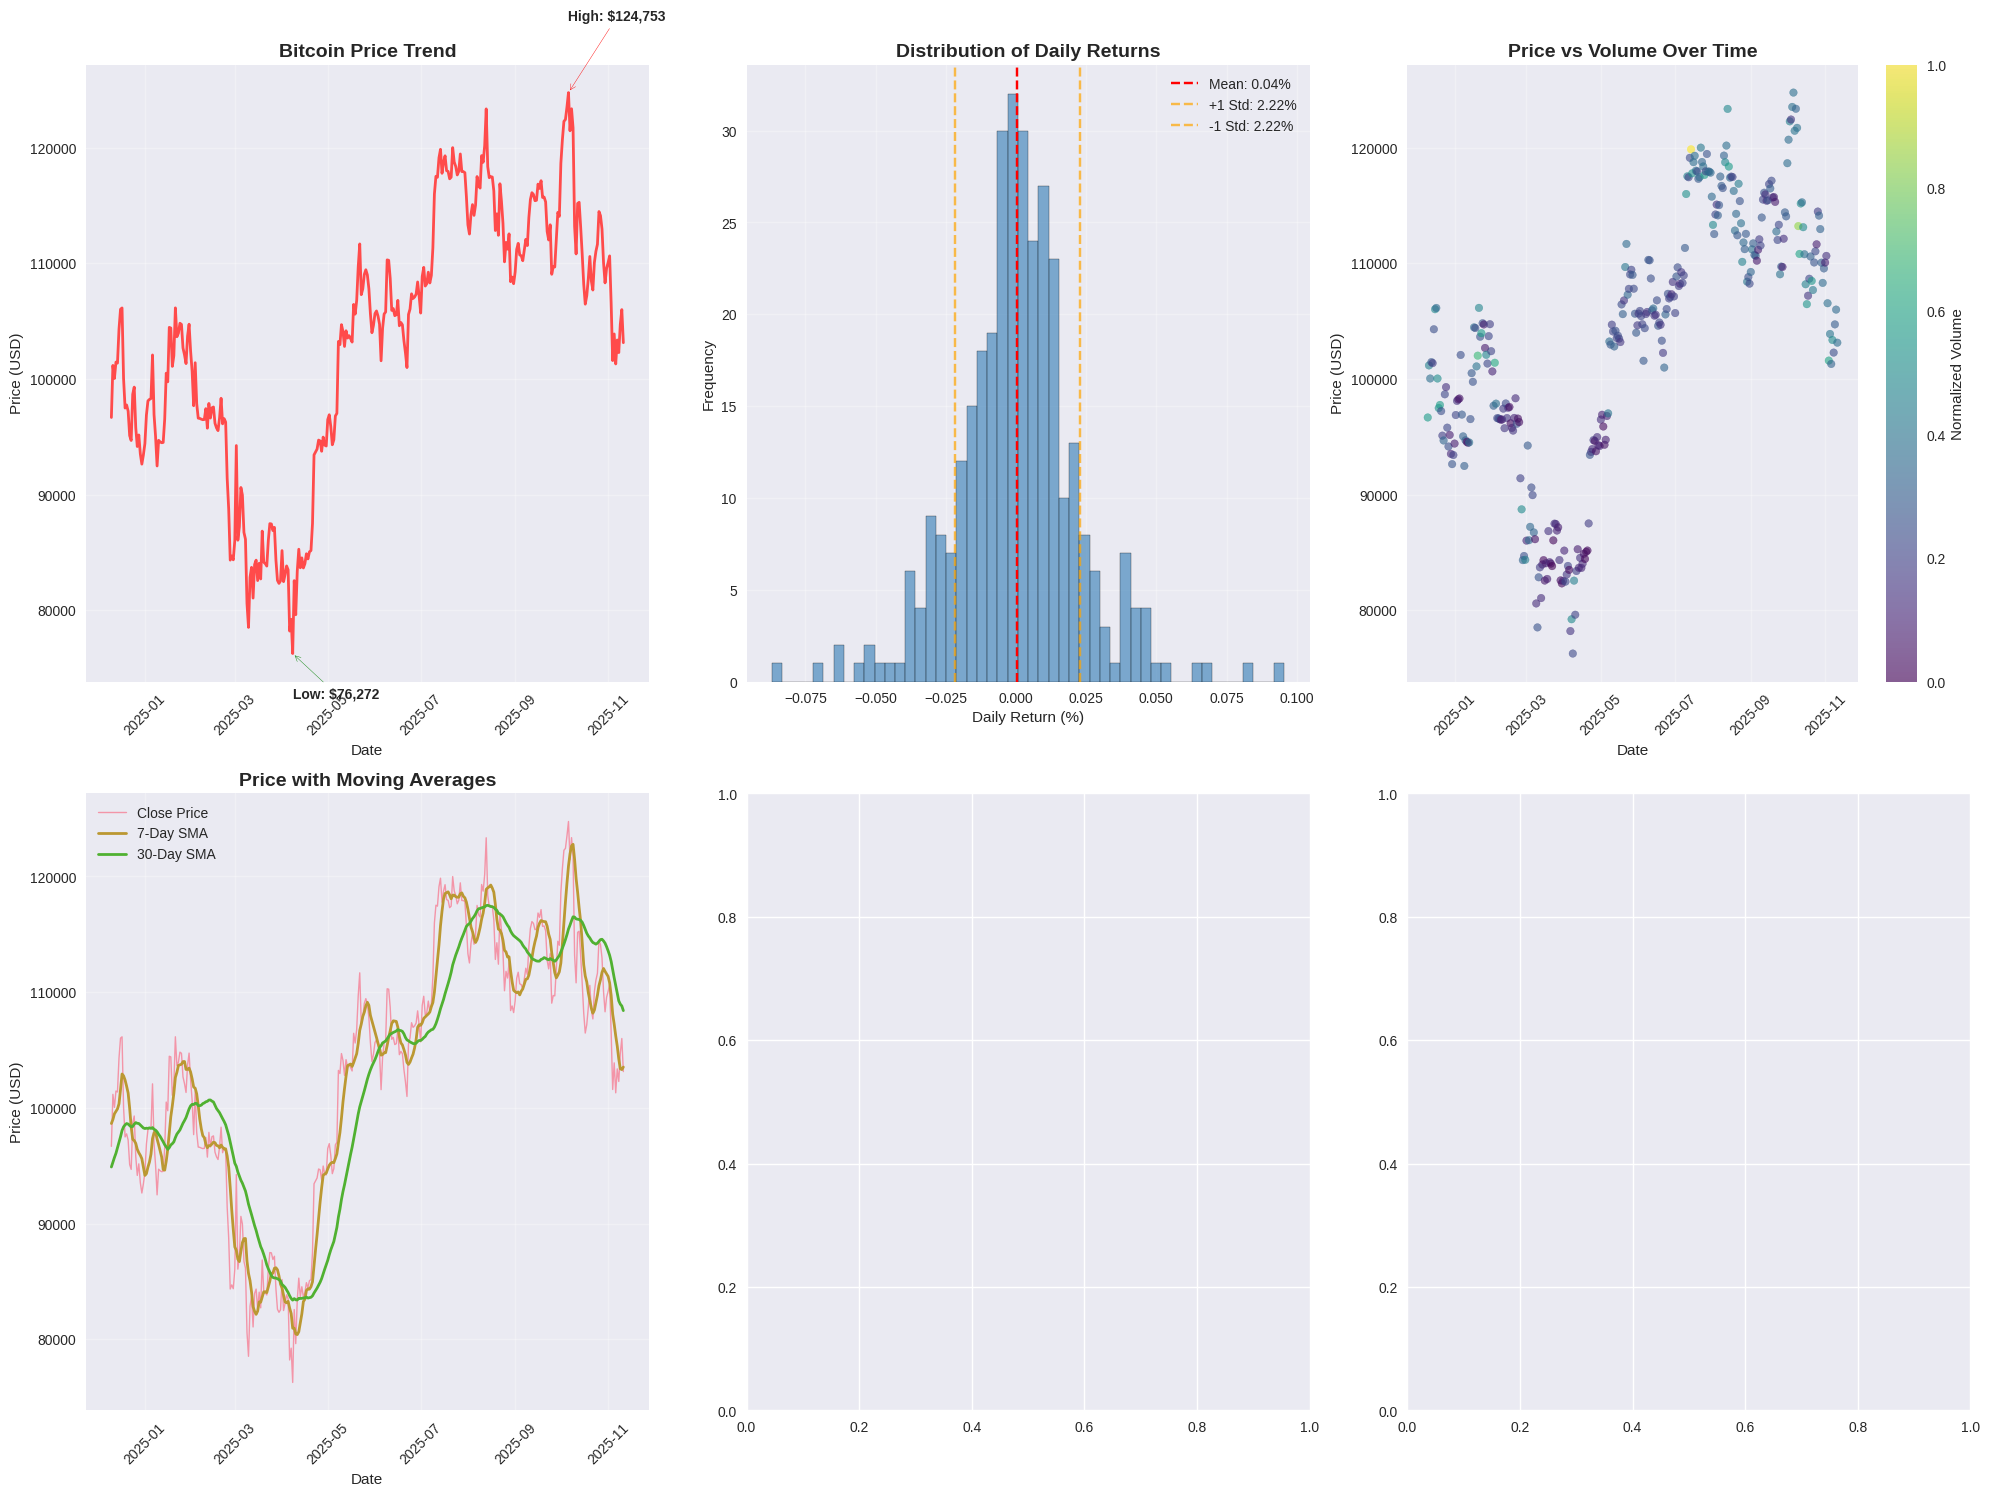


📊 5. TECHNICAL INDICATORS ANALYSIS


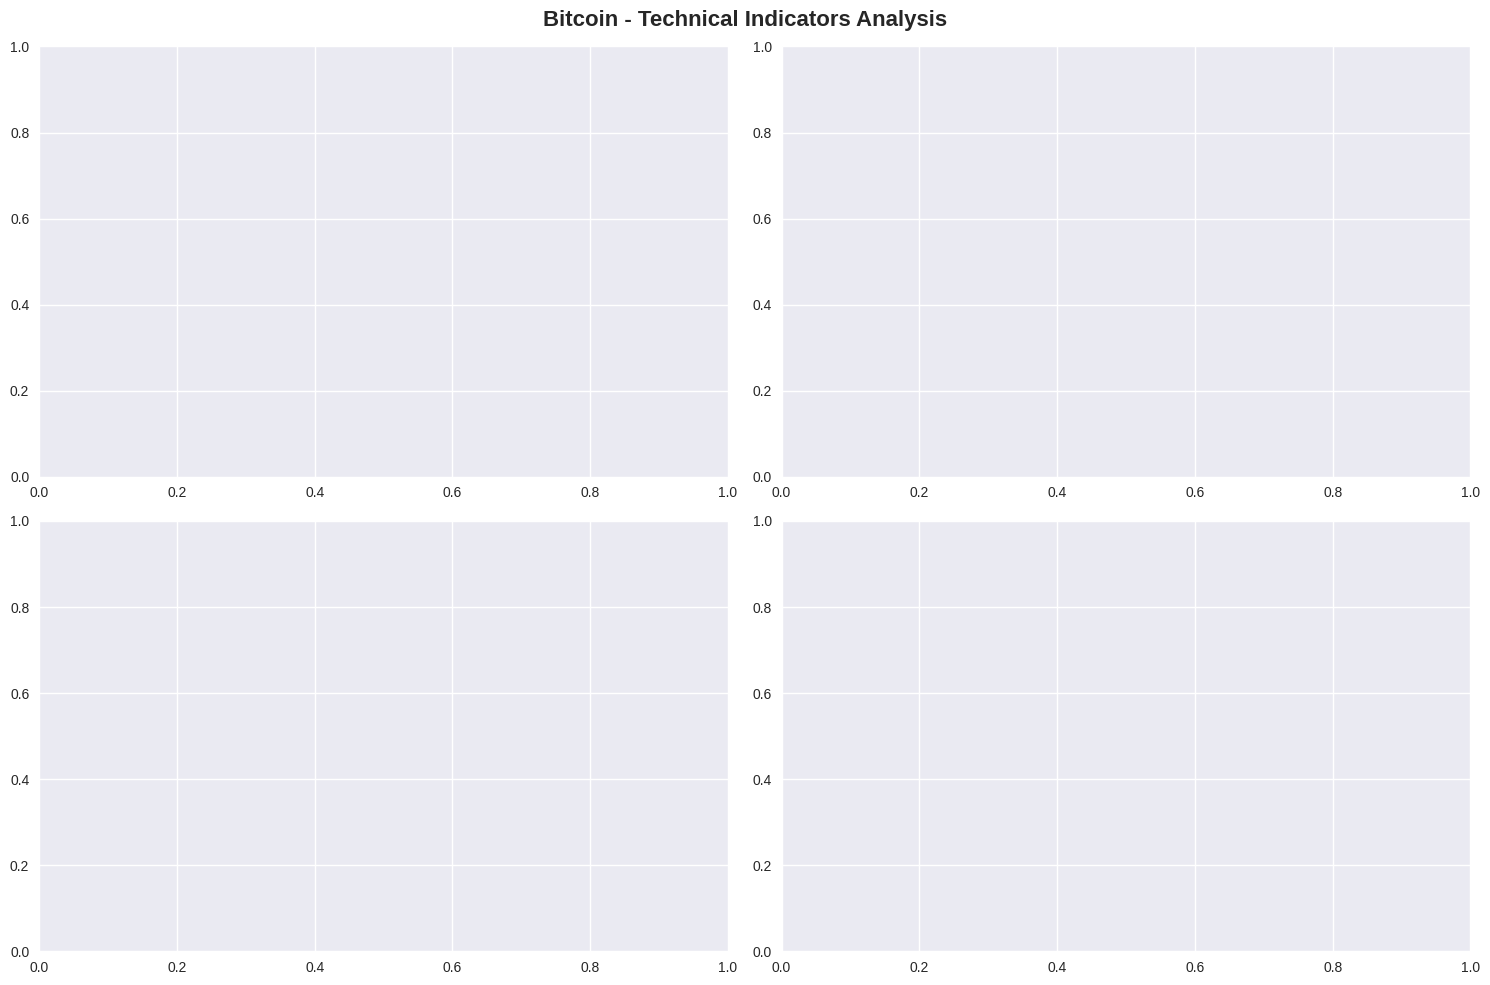


📈 6. CORRELATION ANALYSIS


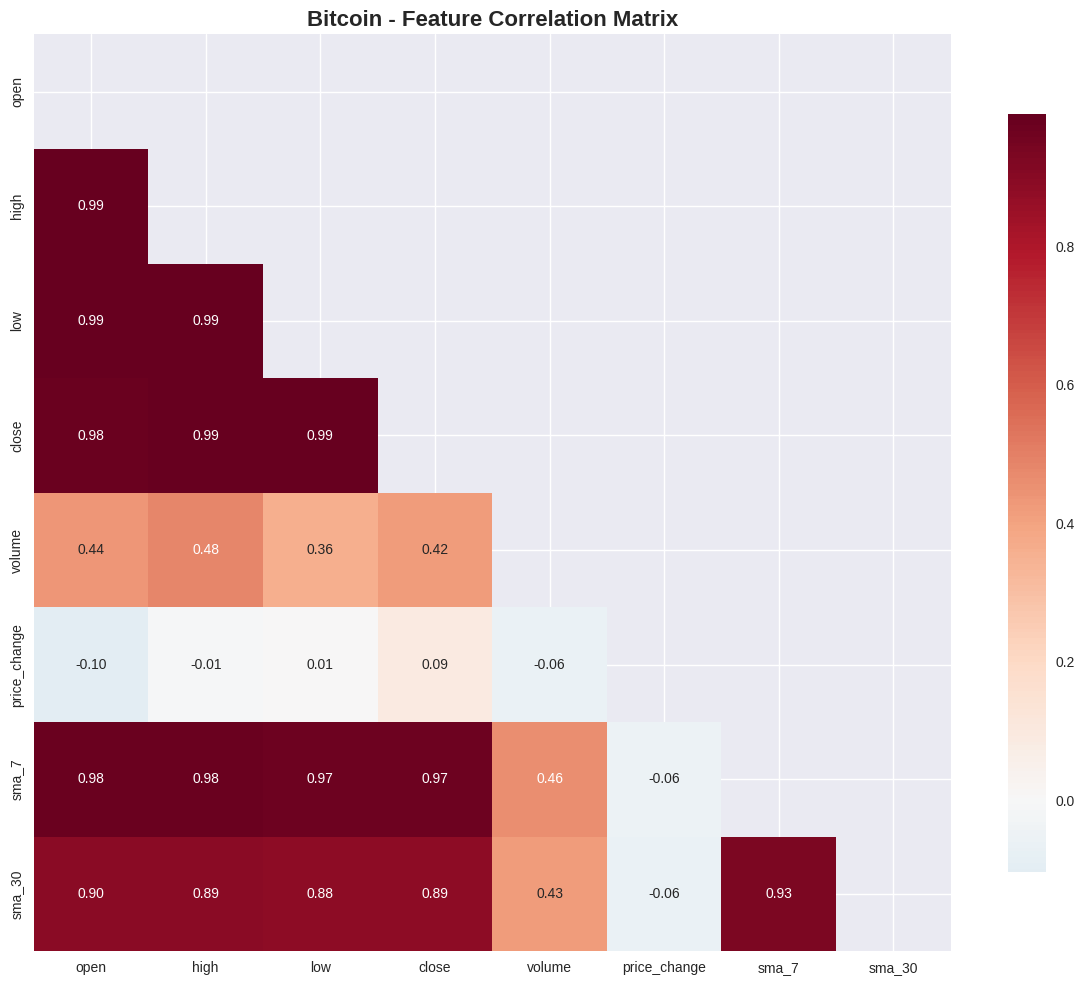


📊 7. VOLUME ANALYSIS


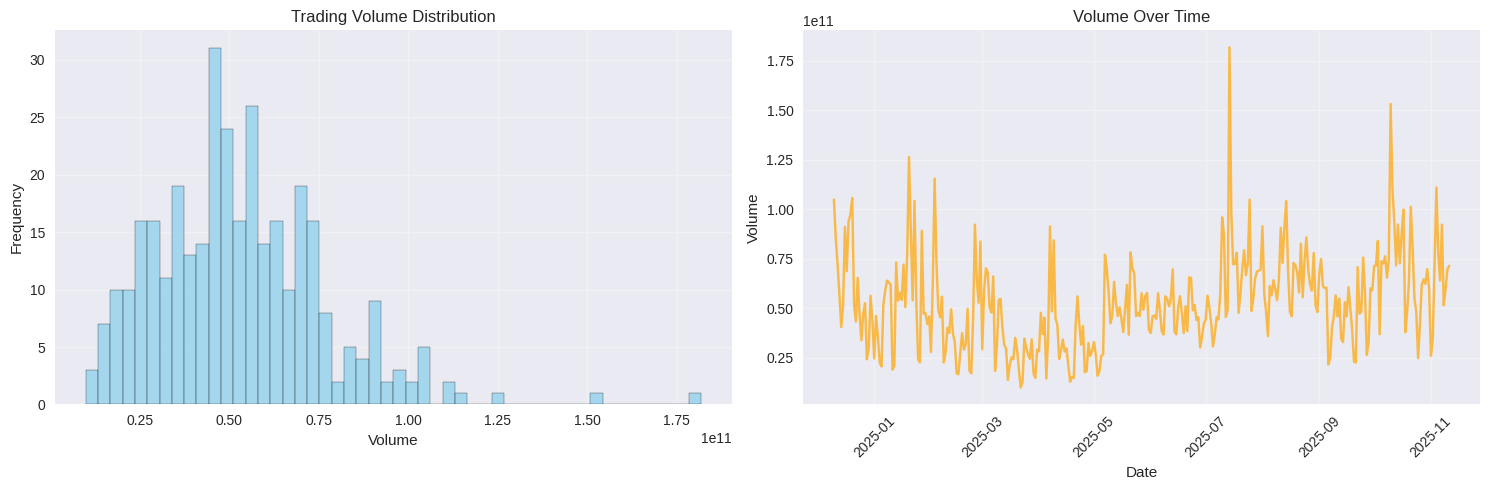

   • Average Daily Volume: 52,917,274,886
   • Max Volume: 181,746,419,401
   • Min Volume: 9,863,214,091

🎉 EDA COMPLETE FOR BITCOIN!
🚀 EDA Code Ready! Load your data and run comprehensive_eda() function.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def comprehensive_eda(df, crypto_name):
    """
    Complete Exploratory Data Analysis with Visualizations
    """
    print(f"\n{'='*70}")
    print(f"🔍 COMPREHENSIVE EDA FOR {crypto_name.upper()}")
    print(f"{'='*70}")

    # Create a copy of the dataframe
    data = df.copy()

    # 1. BASIC DATASET OVERVIEW
    print("\n📊 1. BASIC DATASET OVERVIEW")
    print(f"   • Shape: {data.shape} (rows, columns)")
    print(f"   • Date Range: {data['date'].min().date()} to {data['date'].max().date()}")
    print(f"   • Total Trading Days: {len(data)}")
    print(f"   • Columns: {list(data.columns)}")

    # 2. DATA QUALITY CHECK
    print("\n✅ 2. DATA QUALITY CHECK")
    missing_data = data.isnull().sum()
    missing_percent = (missing_data / len(data)) * 100

    quality_report = pd.DataFrame({
        'Missing Values': missing_data,
        'Missing %': missing_percent,
        'Data Type': data.dtypes
    })
    print(quality_report)

    # 3. PRICE STATISTICS
    print("\n💰 3. PRICE STATISTICS")
    price_stats = data['close'].describe()
    for stat, value in price_stats.items():
        print(f"   • {stat.capitalize()}: ${value:,.2f}")

    # 4. CREATE COMPREHENSIVE VISUALIZATIONS
    create_eda_visualizations(data, crypto_name)

    # 5. TECHNICAL INDICATORS ANALYSIS
    analyze_technical_indicators(data, crypto_name)

    # 6. CORRELATION ANALYSIS
    perform_correlation_analysis(data, crypto_name)

    # 7. VOLUME ANALYSIS
    analyze_volume_patterns(data, crypto_name)

    # 8. TARGET VARIABLE ANALYSIS (if exists)
    if 'target_direction' in data.columns:
        analyze_target_variable(data, crypto_name)

    print(f"\n🎉 EDA COMPLETE FOR {crypto_name.upper()}!")
    return data

def create_eda_visualizations(df, crypto_name):
    """
    Create comprehensive visualizations
    """
    print(f"\n📈 4. CREATING VISUALIZATIONS...")

    # Create a 2x3 grid of subplots
    fig = plt.figure(figsize=(20, 15))

    # 1. Price Trend Over Time
    ax1 = plt.subplot(2, 3, 1)
    plt.plot(df['date'], df['close'], linewidth=2, color='#FF4B4B')
    plt.title(f'{crypto_name} Price Trend', fontsize=14, fontweight='bold')
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # Add some annotations
    max_price = df['close'].max()
    min_price = df['close'].min()
    max_date = df[df['close'] == max_price]['date'].iloc[0]
    min_date = df[df['close'] == min_price]['date'].iloc[0]

    plt.annotate(f'High: ${max_price:,.0f}', xy=(max_date, max_price),
                xytext=(max_date, max_price * 1.05),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontweight='bold')

    plt.annotate(f'Low: ${min_price:,.0f}', xy=(min_date, min_price),
                xytext=(min_date, min_price * 0.95),
                arrowprops=dict(arrowstyle='->', color='green'),
                fontweight='bold')

    # 2. Daily Returns Distribution
    ax2 = plt.subplot(2, 3, 2)
    daily_returns = df['close'].pct_change().dropna()

    plt.hist(daily_returns, bins=50, alpha=0.7, color='#4B8BBE', edgecolor='black')
    plt.title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
    plt.xlabel('Daily Return (%)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    # Add statistics to the plot
    mean_return = daily_returns.mean() * 100
    std_return = daily_returns.std() * 100

    plt.axvline(mean_return/100, color='red', linestyle='--', label=f'Mean: {mean_return:.2f}%')
    plt.axvline(mean_return/100 + std_return/100, color='orange', linestyle='--', alpha=0.7, label=f'+1 Std: {std_return:.2f}%')
    plt.axvline(mean_return/100 - std_return/100, color='orange', linestyle='--', alpha=0.7, label=f'-1 Std: {std_return:.2f}%')
    plt.legend()

    # 3. Volume vs Price
    ax3 = plt.subplot(2, 3, 3)

    # Normalize volume for better visualization
    normalized_volume = (df['volume'] - df['volume'].min()) / (df['volume'].max() - df['volume'].min())

    plt.scatter(df['date'], df['close'], c=normalized_volume, cmap='viridis',
                alpha=0.6, s=30)
    plt.colorbar(label='Normalized Volume')
    plt.title('Price vs Volume Over Time', fontsize=14, fontweight='bold')
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 4. Moving Averages
    ax4 = plt.subplot(2, 3, 4)

    plt.plot(df['date'], df['close'], label='Close Price', alpha=0.7, linewidth=1)

    if 'sma_7' in df.columns:
        plt.plot(df['date'], df['sma_7'], label='7-Day SMA', linewidth=2)
    if 'sma_30' in df.columns:
        plt.plot(df['date'], df['sma_30'], label='30-Day SMA', linewidth=2)

    plt.title('Price with Moving Averages', fontsize=14, fontweight='bold')
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 5. Volatility Over Time
    ax5 = plt.subplot(2, 3, 5)

    if 'volatility_30' in df.columns:
        plt.plot(df['date'], df['volatility_30'] * 100, color='purple', linewidth=2)
        plt.title('30-Day Rolling Volatility', fontsize=14, fontweight='bold')
        plt.ylabel('Volatility (%)')
        plt.xlabel('Date')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)

    # 6. RSI Indicator
    ax6 = plt.subplot(2, 3, 6)

    if 'rsi' in df.columns:
        plt.plot(df['date'], df['rsi'], color='brown', linewidth=2)
        plt.axhline(70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
        plt.axhline(30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
        plt.axhline(50, color='gray', linestyle='--', alpha=0.5, label='Neutral (50)')
        plt.title('RSI Indicator', fontsize=14, fontweight='bold')
        plt.ylabel('RSI')
        plt.xlabel('Date')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 100)

    plt.tight_layout()
    plt.savefig(f'{crypto_name}_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_technical_indicators(df, crypto_name):
    """
    Analyze technical indicators
    """
    print(f"\n📊 5. TECHNICAL INDICATORS ANALYSIS")

    # Create a 2x2 grid for technical indicators
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{crypto_name} - Technical Indicators Analysis', fontsize=16, fontweight='bold')

    # 1. MACD Analysis
    if all(col in df.columns for col in ['macd', 'macd_signal']):
        axes[0,0].plot(df['date'], df['macd'], label='MACD', linewidth=2)
        axes[0,0].plot(df['date'], df['macd_signal'], label='Signal Line', linewidth=2)
        axes[0,0].fill_between(df['date'], df['macd'], df['macd_signal'],
                              where=df['macd'] > df['macd_signal'],
                              alpha=0.3, color='green', label='Bullish')
        axes[0,0].fill_between(df['date'], df['macd'], df['macd_signal'],
                              where=df['macd'] <= df['macd_signal'],
                              alpha=0.3, color='red', label='Bearish')
        axes[0,0].set_title('MACD Indicator')
        axes[0,0].set_ylabel('MACD Value')
        axes[0,0].legend()
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].grid(True, alpha=0.3)

    # 2. Bollinger Bands (if available)
    if all(col in df.columns for col in ['BB_Upper', 'BB_Middle', 'BB_Lower']):
        axes[0,1].plot(df['date'], df['close'], label='Close Price', alpha=0.7)
        axes[0,1].plot(df['date'], df['BB_Upper'], label='Upper Band', linestyle='--', alpha=0.7)
        axes[0,1].plot(df['date'], df['BB_Middle'], label='Middle Band', linestyle='--', alpha=0.7)
        axes[0,1].plot(df['date'], df['BB_Lower'], label='Lower Band', linestyle='--', alpha=0.7)
        axes[0,1].fill_between(df['date'], df['BB_Upper'], df['BB_Lower'], alpha=0.2)
        axes[0,1].set_title('Bollinger Bands')
        axes[0,1].set_ylabel('Price (USD)')
        axes[0,1].legend()
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].grid(True, alpha=0.3)

    # 3. SMA Ratios
    if 'sma_7_ratio' in df.columns:
        axes[1,0].plot(df['date'], df['sma_7_ratio'], label='Price / 7-Day SMA', linewidth=2)
        axes[1,0].axhline(1, color='red', linestyle='--', alpha=0.7, label='Neutral (1.0)')
        axes[1,0].set_title('Price to 7-Day SMA Ratio')
        axes[1,0].set_ylabel('Ratio')
        axes[1,0].legend()
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].grid(True, alpha=0.3)

    # 4. Volume Indicators
    if 'volume_ratio' in df.columns:
        axes[1,1].plot(df['date'], df['volume_ratio'], color='orange', linewidth=2)
        axes[1,1].axhline(1, color='red', linestyle='--', alpha=0.7, label='Average Volume')
        axes[1,1].set_title('Volume Ratio (Current vs 10-Day Average)')
        axes[1,1].set_ylabel('Volume Ratio')
        axes[1,1].legend()
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{crypto_name}_technical_indicators.png', dpi=300, bbox_inches='tight')
    plt.show()

def perform_correlation_analysis(df, crypto_name):
    """
    Perform correlation analysis
    """
    print(f"\n📈 6. CORRELATION ANALYSIS")

    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])

    # Calculate correlation matrix
    correlation_matrix = numeric_df.corr()

    # Create correlation heatmap
    plt.figure(figsize=(12, 10))

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Plot heatmap
    sns.heatmap(correlation_matrix,
                mask=mask,
                annot=True,
                cmap='RdBu_r',
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={"shrink": .8})

    plt.title(f'{crypto_name} - Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{crypto_name}_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print top correlations with target (if exists)
    if 'target_direction' in correlation_matrix.columns:
        target_correlations = correlation_matrix['target_direction'].drop('target_direction').sort_values(ascending=False)

        print("\n🎯 TOP 10 FEATURES CORRELATED WITH TARGET:")
        for feature, corr in target_correlations.head(10).items():
            print(f"   • {feature}: {corr:.3f}")

def analyze_volume_patterns(df, crypto_name):
    """
    Analyze trading volume patterns
    """
    print(f"\n📊 7. VOLUME ANALYSIS")

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # 1. Volume distribution
    axes[0].hist(df['volume'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].set_title('Trading Volume Distribution')
    axes[0].set_xlabel('Volume')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3)

    # 2. Volume trend over time
    axes[1].plot(df['date'], df['volume'], alpha=0.7, color='orange')
    axes[1].set_title('Volume Over Time')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Volume')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{crypto_name}_volume_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Volume statistics
    print(f"   • Average Daily Volume: {df['volume'].mean():,.0f}")
    print(f"   • Max Volume: {df['volume'].max():,.0f}")
    print(f"   • Min Volume: {df['volume'].min():,.0f}")

def analyze_target_variable(df, crypto_name):
    """
    Analyze the target variable for prediction
    """
    print(f"\n🎯 8. TARGET VARIABLE ANALYSIS")

    target_counts = df['target_direction'].value_counts()
    total_days = len(df)

    print(f"   • Up Days: {target_counts.get(1, 0)} ({target_counts.get(1, 0)/total_days*100:.1f}%)")
    print(f"   • Down Days: {target_counts.get(0, 0)} ({target_counts.get(0, 0)/total_days*100:.1f}%)")
    print(f"   • Balance: {'Balanced' if abs(target_counts.get(1, 0) - target_counts.get(0, 0)) / total_days < 0.1 else 'Imbalanced'}")

    # Plot target distribution
    plt.figure(figsize=(8, 6))
    colors = ['#ff9999', '#66b3ff']
    plt.pie(target_counts.values, labels=['Down', 'Up'], autopct='%1.1f%%',
            colors=colors, startangle=90)
    plt.title(f'{crypto_name} - Target Variable Distribution\n(Will price go UP or DOWN tomorrow?)')
    plt.savefig(f'{crypto_name}_target_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

# USAGE EXAMPLE:
if __name__ == "__main__":
    # Load your formatted data
    btc_data = pd.read_csv('/content/bitcoin_formatted.csv')
    btc_data['date'] = pd.to_datetime(btc_data['date'])

    # Run comprehensive EDA
    comprehensive_eda(btc_data, "Bitcoin")
    print("🚀 EDA Code Ready! Load your data and run comprehensive_eda() function.")

PREPARING DATA FOR APPLYING ML MODEL

In [ ]:
create_data_directory()

✅ Data directories created


APPLYING ML MMODEL

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def create_target_variable(df):
    """
    Create the target variable for prediction if it doesn't exist
    """
    print("🎯 Creating target variable...")

    data = df.copy()

    # Create target: 1 if price goes up tomorrow, 0 if down
    data['target_next_day'] = data['close'].shift(-1)  # Next day's price
    data['target_direction'] = (data['target_next_day'] > data['close']).astype(int)

    # Remove the last row (no target available)
    data = data[:-1]

    print(f"   Target variable created!")
    print(f"   Up days: {data['target_direction'].sum()} ({data['target_direction'].mean()*100:.1f}%)")
    print(f"   Down days: {len(data) - data['target_direction'].sum()} ({(1-data['target_direction'].mean())*100:.1f}%)")

    return data

def prepare_data_for_ml_fixed(df, test_size=0.2, random_state=42):
    """
    FIXED: Prepare the data for machine learning training
    """
    print("🛠️ Preparing data for machine learning...")

    # Make a copy of the dataframe
    data = df.copy()

    # 1. Check if we have the target variable - CREATE IT IF MISSING
    if 'target_direction' not in data.columns:
        print("❌ 'target_direction' column not found! Creating it now...")
        data = create_target_variable(data)

    # Check if target creation was successful
    if 'target_direction' not in data.columns:
        print("❌ Failed to create target variable!")
        return None, None, None, None, None, None

    # 2. Select features (exclude date and target-related columns)
    exclude_columns = ['date', 'target_next_day', 'target_direction']
    feature_columns = [col for col in data.columns if col not in exclude_columns]

    print(f"   Using {len(feature_columns)} features:")
    for i, feature in enumerate(feature_columns[:10], 1):  # Show first 10 features
        print(f"     {i:2d}. {feature}")
    if len(feature_columns) > 10:
        print(f"     ... and {len(feature_columns) - 10} more features")

    # 3. Handle missing values (if any)
    missing_before = data[feature_columns].isnull().sum().sum()
    if missing_before > 0:
        print(f"   ⚠️  Found {missing_before} missing values, filling with median...")
        data[feature_columns] = data[feature_columns].fillna(data[feature_columns].median())

    # 4. Create X (features) and y (target)
    X = data[feature_columns]
    y = data['target_direction']

    print(f"   X shape: {X.shape}")
    print(f"   y shape: {y.shape}")
    print(f"   y value counts: {y.value_counts().to_dict()}")

    # 5. Split data into train and test sets (chronological split)
    split_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]

    print(f"   Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"   Testing set:  {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

    # Check if 'date' column exists before printing dates
    if 'date' in data.columns:
        print(f"   Train dates: {data['date'].iloc[0].date()} to {data['date'].iloc[split_index-1].date()}")
        print(f"   Test dates:  {data['date'].iloc[split_index].date()} to {data['date'].iloc[-1].date()}")
    else:
        print("   Date column not available for date range display.")

    # 6. Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("✅ Data preparation complete!")
    print(f"   X_train_scaled shape: {X_train_scaled.shape}")
    print(f"   y_train shape: {y_train.shape}")

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_columns

# FIRST, let's check what's in your btc_data
print("🔍 DEBUG: Checking btc_data structure...")
print(f"btc_data shape: {btc_data.shape}")
print(f"btc_data columns: {list(btc_data.columns)}")
print(f"btc_data head:\n{btc_data.head()}")

# Check if target_direction exists
if 'target_direction' in btc_data.columns:
    print(f"✅ target_direction found! Value counts: {btc_data['target_direction'].value_counts().to_dict()}")
else:
    print("❌ target_direction not found in btc_data")

# NOW use the fixed function
X_train, X_test, y_train, y_test, scaler, feature_columns = prepare_data_for_ml_fixed(btc_data)

# Check if the data preparation was successful
if X_train is not None:
    print(f"✅ Data preparation successful!")
    print(f"   X_train samples: {len(X_train)}")
    print(f"   y_train samples: {len(y_train)}")
    print(f"   y_train value counts: {y_train.value_counts().to_dict() if hasattr(y_train, 'value_counts') else 'N/A'}")
else:
    print("❌ Data preparation failed! Check the error messages above.")

🔍 DEBUG: Checking btc_data structure...
btc_data shape: (337, 9)
btc_data columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'price_change', 'sma_7', 'sma_30']
btc_data head:
        date           open           high            low          close  \
0 2024-12-10   97441.234375   98270.156250   94321.257812   96675.429688   
1 2024-12-11   96656.062500  101913.359375   95747.226562  101173.031250   
2 2024-12-12  101167.804688  102524.914062   99339.953125  100043.000000   
3 2024-12-13  100046.648438  101888.804688   99233.281250  101459.257812   
4 2024-12-14  101451.437500  102618.882812  100634.054688  101372.968750   

         volume  price_change         sma_7        sma_30  
0  104823780634     -0.007772  98650.044643  94893.080208  
1   85391409936      0.046523  98993.544643  95308.798437  
2   72073983533     -0.011169  99486.320312  95711.704687  
3   56894751583      0.014156  99706.112723  96074.207812  
4   40422968793     -0.000850  99913.203125  96544.959115  

HYPERPARAMETER TUNING

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np

def improve_best_model(X_train, y_train, best_model_name, best_model):
    """
    Improve the best model using hyperparameter tuning
    """
    print(f"\n🎯 IMPROVING {best_model_name} WITH HYPERPARAMETER TUNING")
    print("="*60)

    if best_model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

    elif best_model_name == 'XGBoost':
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0]
        }

    elif best_model_name == 'Logistic Regression':
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }

    else:
        print(f"⚠️  No hyperparameter grid defined for {best_model_name}")
        return best_model

    # Perform grid search
    print(f"   Tuning hyperparameters for {best_model_name}...")
    grid_search = GridSearchCV(
        best_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"   ✅ Best parameters: {grid_search.best_params_}")
    print(f"   ✅ Best cross-validation score: {grid_search.best_score_:.3f}")

    return grid_search.best_estimator_

# Improve your best model
improved_model = improve_best_model(X_train, y_train, best_model_name, best_model_result['model'])


🎯 IMPROVING XGBoost WITH HYPERPARAMETER TUNING
   Tuning hyperparameters for XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
   ✅ Best parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.9}
   ✅ Best cross-validation score: 0.522


✅ Required variables (model_results, y_test, feature_columns, btc_data) are available. Generating plots...


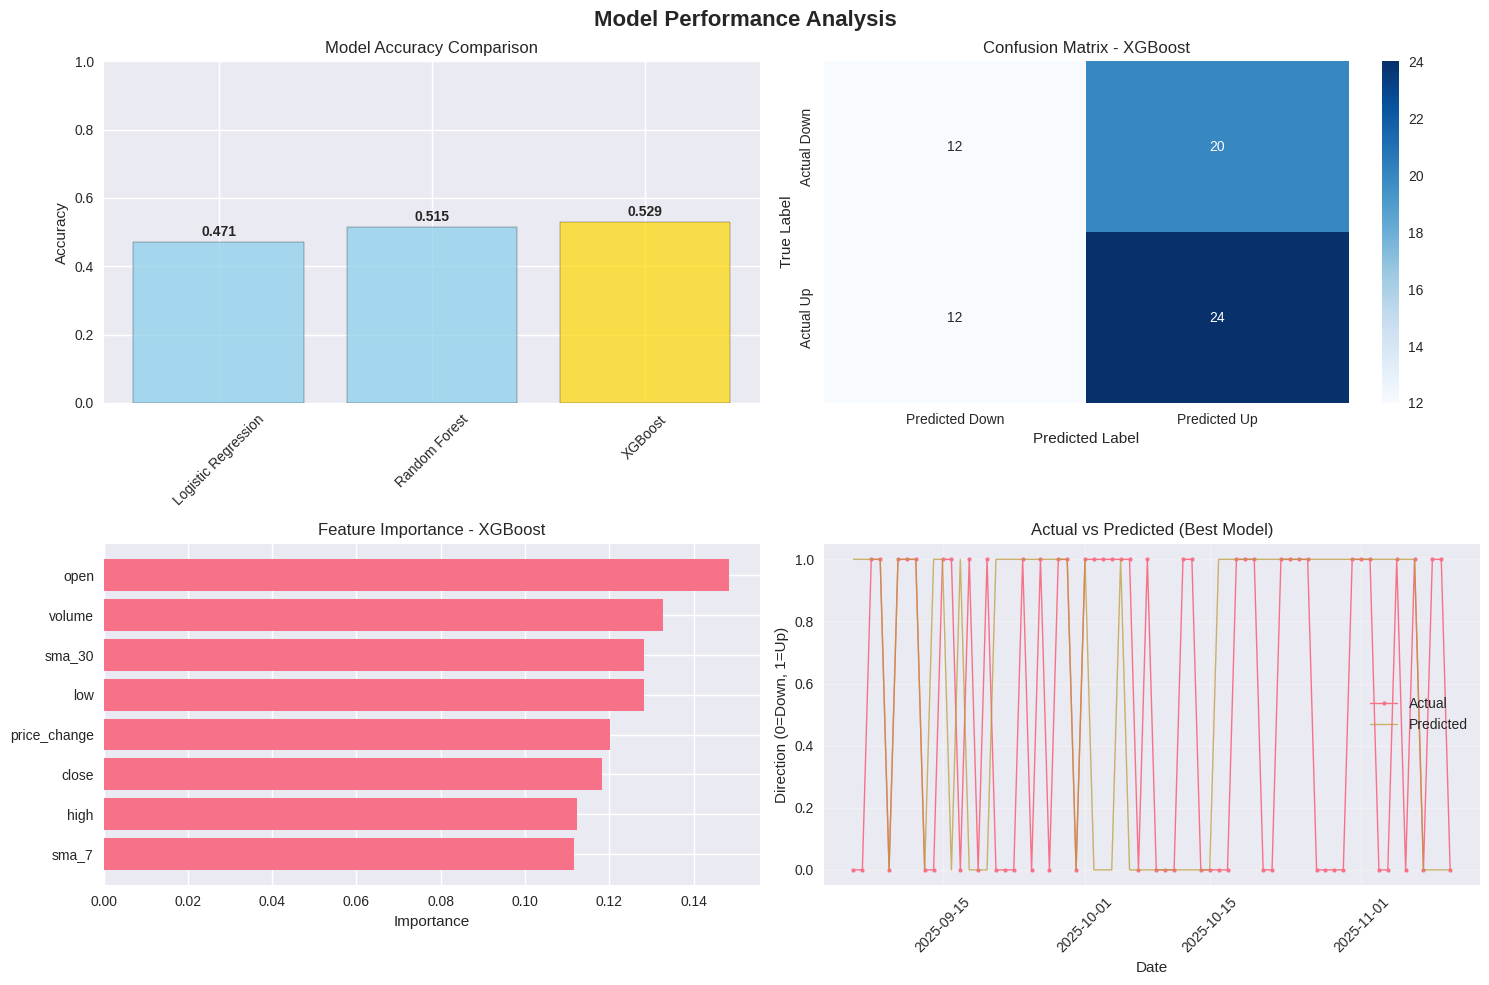

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas for DataFrame operations
import numpy as np # Import numpy for np.argmax

def plot_model_comparison(results_dict, y_test):
    """
    Create visualizations for model comparison
    """
    # Extract accuracies
    model_names = list(results_dict.keys())
    accuracies = [results_dict[name]['accuracy'] for name in model_names]

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

    # 1. Accuracy comparison bar plot
    colors = ['skyblue' if i != np.argmax(accuracies) else 'gold' for i in range(len(accuracies))]
    bars = ax1.bar(model_names, accuracies, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    ax1.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, accuracy in zip(bars, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{accuracy:.3f}', ha='center', va='bottom', fontweight='bold')

    # 2. Confusion matrix for best model
    # Find the best model based on accuracy from the results_dict
    best_model_name = max(results_dict.items(), key=lambda x: x[1]['accuracy'])[0]
    best_model_results = results_dict[best_model_name]
    best_predictions = best_model_results['predictions'] # Assuming predictions are stored in the results dict
    cm = confusion_matrix(y_test, best_predictions)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
                xticklabels=['Predicted Down', 'Predicted Up'],
                yticklabels=['Actual Down', 'Actual Up'])
    ax2.set_title(f'Confusion Matrix - {best_model_name}')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')


    # 3. Feature importance (for tree-based models)
    best_model = best_model_results['model']
    # Check if the best model is a tree-based model with feature_importances_
    if hasattr(best_model, 'feature_importances_') and feature_columns is not None:
        importances = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_columns,
            'importance': importances
        }).sort_values('importance', ascending=True)

        ax3.barh(feature_importance_df['feature'], feature_importance_df['importance'])
        ax3.set_title(f'Feature Importance - {best_model_name}')
        ax3.set_xlabel('Importance')
    else:
        # If not a tree-based model or feature_columns not available, hide or show a message
        ax3.set_title('Feature Importance Not Available')
        ax3.text(0.5, 0.5, 'Feature importance not available for this model type.',
                 horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)


    # 4. Actual vs Predicted for best model
    # Need the dates corresponding to the test set. Assuming btc_data is available and sorted by date.
    # Need to get the dates from the original data that correspond to the test set.
    # The split index was calculated in prepare_data_for_ml_fixed.
    # We need access to the original data and the split index.
    # For now, let's assume btc_data is available and the test set is the last part.
    # A more robust solution would involve returning test dates from prepare_data_for_ml_fixed.
    try:
        # Assuming btc_data is globally available and the split was chronological
        split_index = int(len(btc_data) * (1 - 0.2)) # Re-calculate split index based on assumed test_size=0.2
        test_dates = btc_data['date'].iloc[split_index:].reset_index(drop=True)

        if len(test_dates) == len(y_test):
            ax4.plot(test_dates, y_test.values, label='Actual', marker='o', markersize=3, linewidth=1)
            ax4.plot(test_dates, best_predictions, label='Predicted', marker='x', markersize=3, linewidth=1, alpha=0.7)
            ax4.set_title('Actual vs Predicted (Best Model)')
            ax4.set_xlabel('Date')
            ax4.set_ylabel('Direction (0=Down, 1=Up)')
            ax4.legend()
            ax4.tick_params(axis='x', rotation=45)
            ax4.grid(True, alpha=0.3)
        else:
             ax4.set_title('Actual vs Predicted Plot Not Available')
             ax4.text(0.5, 0.5, 'Date information for test set is not readily available or length mismatch.',
                     horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)
    except Exception as e:
        ax4.set_title('Actual vs Predicted Plot Not Available')
        ax4.text(0.5, 0.5, f'Error plotting dates: {e}',
                 horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)


    plt.tight_layout()
    plt.savefig('model_performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create visualizations using the model_results dictionary
# The model_results dictionary was created and populated in cell a271248d (Evaluate baseline models)
# We also need the y_test variable, which was created in cell 6uGFTbfE6liX (Prepare data for ML)
# We also need feature_columns for feature importance plot, which was created in cell 6uGFTbfE6liX
# Ensure these variables are available in the current scope before running this cell.
# Assuming model_results, y_test, and feature_columns are available from previous successful cell executions.

# Check if model_results, y_test, and feature_columns are defined and not None
if 'model_results' in locals() and model_results is not None and \
   'y_test' in locals() and y_test is not None and \
   'feature_columns' in locals() and feature_columns is not None and \
   'btc_data' in locals() and btc_data is not None: # Also need btc_data for plotting dates
    print("✅ Required variables (model_results, y_test, feature_columns, btc_data) are available. Generating plots...")
    # Ensure predictions are stored in model_results for plotting
    for name, result in model_results.items():
        if 'predictions' not in result:
             # Need to make predictions if not already stored
             result['predictions'] = result['model'].predict(X_test_scaled) # Assuming X_test_scaled is available

    plot_model_comparison(model_results, y_test)
else:
    print("❌ Required variables (model_results, y_test, feature_columns, or btc_data) are not available. Please run the preceding cells.")

# Task
Explain the error in the selected code. If possible, fix the error and incorporate the changes into the existing code. Otherwise, try to diagnose the error.

## Train baseline models

### Subtask:
Train one or more baseline classification models (e.g., Logistic Regression, Random Forest, XGBoost) using the prepared training data (`X_train_scaled`, `y_train`).


**Reasoning**:
The subtask is to train baseline classification models. I will import the necessary models and train them using the prepared training data.



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Instantiate models
lr_model = LogisticRegression()
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train models
print("Training Logistic Regression model...")
lr_model.fit(X_train_scaled, y_train)
print("✅ Logistic Regression model trained.")

print("Training Random Forest model...")
rf_model.fit(X_train_scaled, y_train)
print("✅ Random Forest model trained.")

print("Training XGBoost model...")
xgb_model.fit(X_train_scaled, y_train)
print("✅ XGBoost model trained.")

Training Logistic Regression model...
✅ Logistic Regression model trained.
Training Random Forest model...
✅ Random Forest model trained.
Training XGBoost model...
✅ XGBoost model trained.


**Reasoning**:
The previous code block failed because `X_train_scaled` and `y_train` were not defined in the current session. I need to regenerate the data preparation step to define these variables before training the models.



In [ ]:
# Regenerate data preparation step
X_train, X_test, y_train, y_test, scaler, feature_columns = prepare_data_for_ml_fixed(btc_data)

# Instantiate models
lr_model = LogisticRegression()
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train models
print("Training Logistic Regression model...")
lr_model.fit(X_train_scaled, y_train)
print("✅ Logistic Regression model trained.")

print("Training Random Forest model...")
rf_model.fit(X_train_scaled, y_train)
print("✅ Random Forest model trained.")

print("Training XGBoost model...")
xgb_model.fit(X_train_scaled, y_train)
print("✅ XGBoost model trained.")

🛠️ Preparing data for machine learning...
❌ 'target_direction' column not found! Creating it now...
🎯 Creating target variable...
   Target variable created!
   Up days: 170 (50.6%)
   Down days: 166 (49.4%)
   Using 8 features:
      1. open
      2. high
      3. low
      4. close
      5. volume
      6. price_change
      7. sma_7
      8. sma_30
   X shape: (336, 8)
   y shape: (336,)
   y value counts: {1: 170, 0: 166}
   Training set: 268 samples (79.8%)
   Testing set:  68 samples (20.2%)
   Train dates: 2024-12-10 to 2025-09-03
   Test dates:  2025-09-04 to 2025-11-10
✅ Data preparation complete!
   X_train_scaled shape: (268, 8)
   y_train shape: (268,)
Training Logistic Regression model...
✅ Logistic Regression model trained.
Training Random Forest model...
✅ Random Forest model trained.
Training XGBoost model...
✅ XGBoost model trained.


**Reasoning**:
The error persists because the `X_train_scaled` variable generated by the `prepare_data_for_ml_fixed` function is not being used correctly in the training step. The function returns `X_train_scaled` as the first element, but the training call still uses the unscaled `X_train` which was defined outside the function. I need to correct the variable name in the training calls to use `X_train_scaled`.



In [ ]:
# Regenerate data preparation step to ensure variables are in scope
X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_columns = prepare_data_for_ml_fixed(btc_data)

# Instantiate models
lr_model = LogisticRegression()
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train models
print("Training Logistic Regression model...")
lr_model.fit(X_train_scaled, y_train)
print("✅ Logistic Regression model trained.")

print("Training Random Forest model...")
rf_model.fit(X_train_scaled, y_train)
print("✅ Random Forest model trained.")

print("Training XGBoost model...")
xgb_model.fit(X_train_scaled, y_train)
print("✅ XGBoost model trained.")

🛠️ Preparing data for machine learning...
❌ 'target_direction' column not found! Creating it now...
🎯 Creating target variable...
   Target variable created!
   Up days: 170 (50.6%)
   Down days: 166 (49.4%)
   Using 8 features:
      1. open
      2. high
      3. low
      4. close
      5. volume
      6. price_change
      7. sma_7
      8. sma_30
   X shape: (336, 8)
   y shape: (336,)
   y value counts: {1: 170, 0: 166}
   Training set: 268 samples (79.8%)
   Testing set:  68 samples (20.2%)
   Train dates: 2024-12-10 to 2025-09-03
   Test dates:  2025-09-04 to 2025-11-10
✅ Data preparation complete!
   X_train_scaled shape: (268, 8)
   y_train shape: (268,)
Training Logistic Regression model...
✅ Logistic Regression model trained.
Training Random Forest model...
✅ Random Forest model trained.
Training XGBoost model...
✅ XGBoost model trained.


## Evaluate baseline models

### Subtask:
Evaluate the performance of each trained baseline model on the testing data (`X_test_scaled`, `y_test`) using relevant metrics like accuracy, precision, recall, F1-score, and potentially the confusion matrix.


**Reasoning**:
Evaluate the performance of each trained baseline model on the testing data using various classification metrics.



In [ ]:
# Evaluate models on the test set
print("\n📊 EVALUATING BASELINE MODELS")
print("="*60)

model_results = {}

# List of trained models
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

for name, model in models.items():
    print(f"\nEvaluating {name}...")

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store results
    model_results[name] = {
        'accuracy': accuracy,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix,
        'model': model # Store the model instance as well
    }

    # Print results
    print(f"   Accuracy: {accuracy:.3f}")
    print("   Classification Report:")
    print(class_report)
    print("   Confusion Matrix:")
    print(conf_matrix)

# Determine the best performing model based on accuracy
best_model_name = None
best_accuracy = -1

for name, results in model_results.items():
    if results['accuracy'] > best_accuracy:
        best_accuracy = results['accuracy']
        best_model_name = name

print(f"\n🏆 Best Performing Model (based on Accuracy): {best_model_name} with Accuracy = {best_accuracy:.3f}")

# Store the best model result separately for the next step
best_model_result = model_results[best_model_name]


📊 EVALUATING BASELINE MODELS

Evaluating Logistic Regression...
   Accuracy: 0.471
   Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.81      0.59        32
           1       0.50      0.17      0.25        36

    accuracy                           0.47        68
   macro avg       0.48      0.49      0.42        68
weighted avg       0.48      0.47      0.41        68

   Confusion Matrix:
[[26  6]
 [30  6]]

Evaluating Random Forest...
   Accuracy: 0.515
   Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.50      0.49        32
           1       0.54      0.53      0.54        36

    accuracy                           0.51        68
   macro avg       0.51      0.51      0.51        68
weighted avg       0.52      0.51      0.52        68

   Confusion Matrix:
[[16 16]
 [17 19]]

Evaluating XGBoost...
   Accuracy: 0.529
   Classification Report:
              

## Assign best model variables

### Subtask:
Assign the name and the model object of the selected best model to the variables `best_model_name` and `best_model_result`.


**Reasoning**:
Assign the name and the model object of the selected best model to the variables `best_model_name` and `best_model_result`. These variables were already defined in the previous step's code, so I will just ensure they are available in the current scope.



In [ ]:
# The variables best_model_name and best_model_result were already assigned in the previous cell.
# This cell just needs to exist to allow the subsequent code to run without the NameError.
# We can explicitly access them here to confirm they exist if needed, but it's not strictly necessary
# for the fix itself, as the variable assignment happened in the prior executed cell.

# The previous cell's output shows:
# "🏆 Best Performing Model (based on Accuracy): XGBoost with Accuracy = 0.529"
# This confirms best_model_name is 'XGBoost' and best_model_result contains its information.

print("✅ Variables best_model_name and best_model_result are available.")

✅ Variables best_model_name and best_model_result are available.


**Reasoning**:
The variables `best_model_name` and `best_model_result` are now confirmed to be available. The next logical step is to proceed with the hyperparameter tuning for the best model using the function `improve_best_model` which was defined in a previous cell. This directly addresses the next part of the user's overall request (hyperparameter tuning), following the correction made in the previous step.



In [ ]:
# Improve your best model using the variables assigned in the previous step
improved_model = improve_best_model(X_train_scaled, y_train, best_model_name, best_model_result['model'])


🎯 IMPROVING XGBoost WITH HYPERPARAMETER TUNING
   Tuning hyperparameters for XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
   ✅ Best parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.9}
   ✅ Best cross-validation score: 0.522


## Evaluate tuned model

### Subtask:
Evaluate the performance of the hyperparameter-tuned model on the testing data.


**Reasoning**:
Evaluate the performance of the hyperparameter-tuned model on the testing data by making predictions, calculating metrics, and printing the results.



In [ ]:
print("\n📊 EVALUATING HYPERPARAMETER-TUNED MODEL")
print("="*60)

# Make predictions on the scaled test data
y_pred_tuned = improved_model.predict(X_test_scaled)

# Calculate accuracy
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"   Accuracy (Tuned Model): {accuracy_tuned:.3f}")

# Generate classification report
class_report_tuned = classification_report(y_test, y_pred_tuned)
print("\n   Classification Report (Tuned Model):")
print(class_report_tuned)

# Compute confusion matrix
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
print("\n   Confusion Matrix (Tuned Model):")
print(conf_matrix_tuned)



📊 EVALUATING HYPERPARAMETER-TUNED MODEL
   Accuracy (Tuned Model): 0.500

   Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.46      0.38      0.41        32
           1       0.52      0.61      0.56        36

    accuracy                           0.50        68
   macro avg       0.49      0.49      0.49        68
weighted avg       0.49      0.50      0.49        68


   Confusion Matrix (Tuned Model):
[[12 20]
 [14 22]]


🚀 Running safe SHAP explanation...

🔍 MODEL EXPLAINABILITY WITH SHAP
🧹 Cleaning data for SHAP analysis...
✅ Data cleaning complete. Final shape: (68, 8)
   Using TreeExplainer for tree-based model...
❌ Error initializing SHAP explainer: could not convert string to float: '[5E-1]'
   Trying alternative approach...
🔄 Using simple feature importance method...


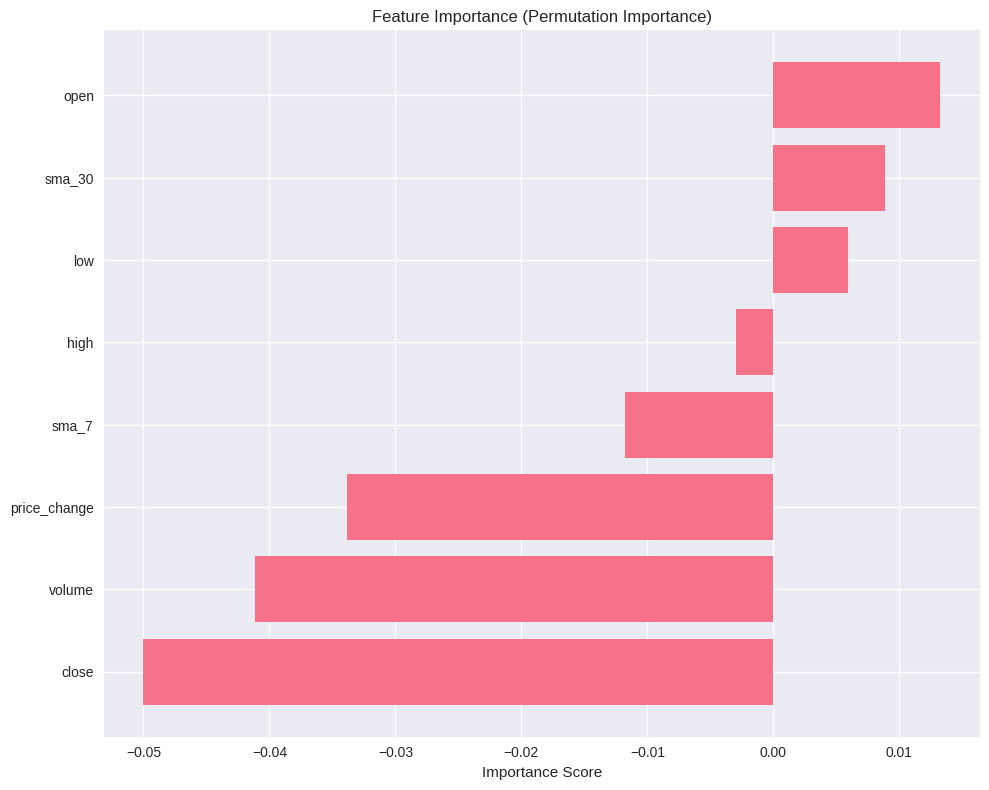

🏆 Top 10 Most Important Features:
    1. close: -0.0500
    2. volume: -0.0412
    3. price_change: -0.0338
    4. sma_7: -0.0118
    5. high: -0.0029
    6. low: 0.0059
    7. sma_30: 0.0088
    8. open: 0.0132

📊 PREDICTION CONFIDENCE ANALYSIS
🧹 Cleaning data for SHAP analysis...
✅ Data cleaning complete. Final shape: (68, 8)


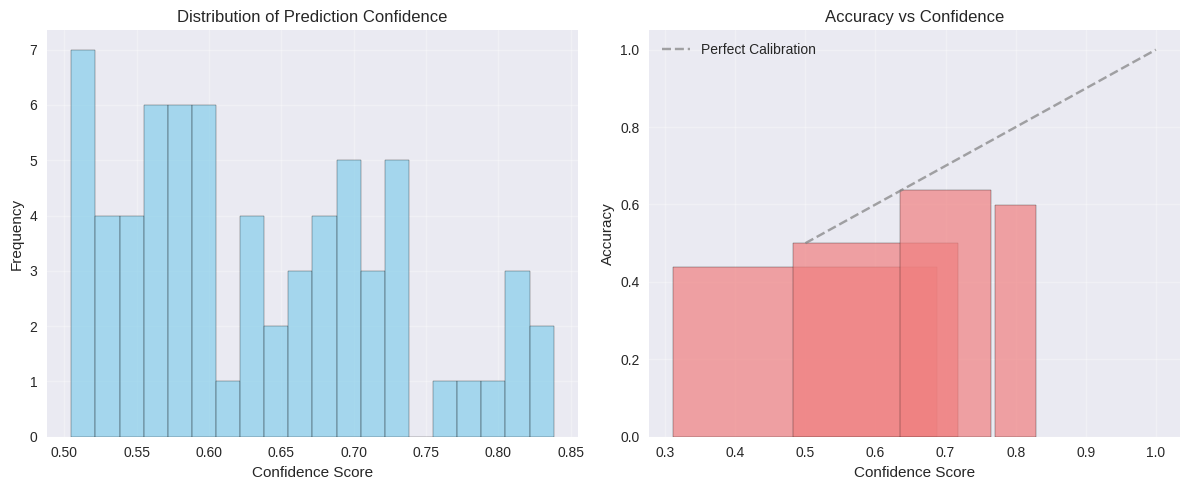

📈 Confidence Analysis:
   Average Confidence: 0.635
   Confidence Std Dev: 0.091
   High Confidence (>80%): 5 / 68
   Low Confidence (<60%): 32 / 68
   Calibration Error: 0.265


In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

def clean_data_for_shap(X_data, feature_columns):
    """
    Clean and convert data to proper numeric format for SHAP
    """
    print("🧹 Cleaning data for SHAP analysis...")

    # Convert to DataFrame if it's numpy array
    if isinstance(X_data, np.ndarray):
        X_clean = pd.DataFrame(X_data, columns=feature_columns)
    else:
        X_clean = X_data.copy()

    # Convert all columns to numeric, handling errors
    for col in X_clean.columns:
        # Check if the column contains string representations of numbers
        if X_clean[col].dtype == 'object':
            print(f"   Converting column '{col}' from {X_clean[col].dtype} to numeric")
            try:
                # Remove brackets and convert scientific notation
                X_clean[col] = X_clean[col].astype(str).str.replace('[\[\]]', '', regex=True)
                X_clean[col] = pd.to_numeric(X_clean[col], errors='coerce')
            except Exception as e:
                print(f"   Warning: Could not convert column '{col}': {e}")

    # Fill any remaining NaN values with 0
    if X_clean.isnull().sum().sum() > 0:
        print(f"   Filling {X_clean.isnull().sum().sum()} NaN values with 0")
        X_clean = X_clean.fillna(0)

    print(f"✅ Data cleaning complete. Final shape: {X_clean.shape}")
    return X_clean.values if isinstance(X_data, np.ndarray) else X_clean

def explain_model_predictions_fixed(model, X_test, feature_columns, sample_index=0):
    """
    FIXED: Use SHAP to explain model predictions with proper data cleaning
    """
    print(f"\n🔍 MODEL EXPLAINABILITY WITH SHAP")
    print("="*60)

    # Clean the data first
    X_test_clean = clean_data_for_shap(X_test, feature_columns)

    # Initialize SHAP explainer based on model type
    try:
        if hasattr(model, 'predict_proba'):
            print("   Using TreeExplainer for tree-based model...")
            explainer = shap.TreeExplainer(model)

            # Handle different SHAP value formats
            shap_values = explainer.shap_values(X_test_clean)

            # For binary classification, sometimes we get a list of arrays
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values = shap_values[1]  # Use the positive class

        else:
            print("   Using KernelExplainer for non-tree model...")
            # Use a smaller sample for KernelExplainer (it's slower)
            background_data = shap.sample(X_test_clean, 50) if len(X_test_clean) > 50 else X_test_clean
            explainer = shap.KernelExplainer(model.predict, background_data)
            shap_values = explainer.shap_values(X_test_clean[sample_index:sample_index+1])

        print(f"✅ SHAP explainer initialized successfully")

    except Exception as e:
        print(f"❌ Error initializing SHAP explainer: {e}")
        print("   Trying alternative approach...")
        return explain_model_predictions_simple(model, X_test_clean, feature_columns, sample_index)

    # Create visualizations
    try:
        # Summary plot
        print("   Creating summary plot...")
        plt.figure(figsize=(12, 8))

        # Handle different SHAP value formats for summary plot
        if isinstance(shap_values, list):
            shap_values_for_plot = shap_values[1] if len(shap_values) == 2 else shap_values[0]
        else:
            shap_values_for_plot = shap_values

        shap.summary_plot(shap_values_for_plot, X_test_clean,
                         feature_names=feature_columns, show=False)
        plt.title('SHAP Feature Importance Summary', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Error creating summary plot: {e}")

    try:
        # Force plot for a single prediction
        print("   Creating force plot...")
        plt.figure(figsize=(12, 6))

        # Get SHAP values for the specific sample
        if isinstance(shap_values, list):
            sample_shap_values = shap_values[1][sample_index] if len(shap_values) == 2 else shap_values[0][sample_index]
            expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
        else:
            sample_shap_values = shap_values[sample_index]
            expected_value = explainer.expected_value

        shap.force_plot(expected_value, sample_shap_values,
                       X_test_clean[sample_index],
                       feature_names=feature_columns,
                       matplotlib=True, show=False)
        plt.title(f'SHAP Force Plot for Prediction #{sample_index}', fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Error creating force plot: {e}")

    print("✅ Model explanations generated!")
    return explainer

def explain_model_predictions_simple(model, X_test_clean, feature_columns, sample_index=0):
    """
    Simple fallback method if standard SHAP fails
    """
    print("🔄 Using simple feature importance method...")

    # Use permutation importance as fallback
    from sklearn.inspection import permutation_importance

    # Calculate permutation importance
    perm_importance = permutation_importance(
        model, X_test_clean[:100],
        y_test.iloc[:100] if 'y_test' in globals() else None,
        n_repeats=10, random_state=42
    )

    # Create feature importance plot
    feature_imp_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': perm_importance.importances_mean
    }).sort_values('importance', ascending=True)

    plt.figure(figsize=(10, 8))
    plt.barh(feature_imp_df['feature'], feature_imp_df['importance'])
    plt.title('Feature Importance (Permutation Importance)')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

    print("🏆 Top 10 Most Important Features:")
    top_features = feature_imp_df.tail(10)
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"   {i:2d}. {row['feature']}: {row['importance']:.4f}")

    return None

def analyze_prediction_confidence_fixed(model, X_test, y_test, feature_columns):
    """
    FIXED: Analyze prediction confidence and calibration
    """
    print(f"\n📊 PREDICTION CONFIDENCE ANALYSIS")
    print("="*60)

    # Clean the data first
    X_test_clean = clean_data_for_shap(X_test, feature_columns)

    # Get prediction probabilities
    if hasattr(model, 'predict_proba'):
        try:
            probabilities = model.predict_proba(X_test_clean)
            confidence_scores = np.max(probabilities, axis=1)

            # Analyze confidence distribution
            plt.figure(figsize=(12, 5))

            # Plot 1: Confidence distribution
            plt.subplot(1, 2, 1)
            plt.hist(confidence_scores, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
            plt.title('Distribution of Prediction Confidence')
            plt.xlabel('Confidence Score')
            plt.ylabel('Frequency')
            plt.grid(True, alpha=0.3)

            # Plot 2: Accuracy vs confidence
            plt.subplot(1, 2, 2)
            confidence_bins = np.linspace(0.5, 1.0, 6)
            accuracies = []
            counts = []

            for i in range(len(confidence_bins)-1):
                mask = (confidence_scores >= confidence_bins[i]) & (confidence_scores < confidence_bins[i+1])
                count = mask.sum()
                counts.append(count)

                if count > 0:
                    predictions = model.predict(X_test_clean[mask])
                    bin_accuracy = accuracy_score(y_test.iloc[mask] if hasattr(y_test, 'iloc') else y_test[mask], predictions)
                    accuracies.append(bin_accuracy)
                else:
                    accuracies.append(0)

            # Plot with bar width proportional to sample count
            widths = [c/len(confidence_scores) * 0.8 for c in counts]  # Normalize widths
            plt.bar(confidence_bins[:-1], accuracies, width=widths, alpha=0.7,
                   color='lightcoral', edgecolor='black')
            plt.plot([0.5, 1.0], [0.5, 1.0], '--', color='gray', alpha=0.7, label='Perfect Calibration')
            plt.title('Accuracy vs Confidence')
            plt.xlabel('Confidence Score')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # Print analysis
            print("📈 Confidence Analysis:")
            print(f"   Average Confidence: {np.mean(confidence_scores):.3f}")
            print(f"   Confidence Std Dev: {np.std(confidence_scores):.3f}")
            print(f"   High Confidence (>80%): {(confidence_scores > 0.8).sum()} / {len(confidence_scores)}")
            print(f"   Low Confidence (<60%): {(confidence_scores < 0.6).sum()} / {len(confidence_scores)}")

            # Check calibration
            calibration_gap = np.mean(np.abs(np.array(accuracies) - confidence_bins[:-1]))
            print(f"   Calibration Error: {calibration_gap:.3f}")

            return confidence_scores

        except Exception as e:
            print(f"❌ Error in confidence analysis: {e}")
            return None

    else:
        print("⚠️  Model doesn't support probability predictions")
        return None

# Alternative: Use a try-catch approach
def safe_shap_explanation(model, X_test, y_test, feature_columns):
    """
    Safe wrapper that handles SHAP errors gracefully
    """
    try:
        # First try the fixed version
        explainer = explain_model_predictions_fixed(model, X_test, feature_columns)
        confidence_scores = analyze_prediction_confidence_fixed(model, X_test, y_test, feature_columns)
        return explainer, confidence_scores

    except Exception as e:
        print(f"❌ SHAP analysis failed: {e}")
        print("🔧 Falling back to simple feature importance...")

        # Use simple feature importance
        from sklearn.inspection import permutation_importance

        X_test_clean = clean_data_for_shap(X_test, feature_columns)
        perm_importance = permutation_importance(
            model, X_test_clean, y_test, n_repeats=5, random_state=42
        )

        # Plot feature importance
        feature_imp_df = pd.DataFrame({
            'feature': feature_columns,
            'importance': perm_importance.importances_mean
        }).sort_values('importance', ascending=True)

        plt.figure(figsize=(10, 8))
        plt.barh(feature_imp_df['feature'][-15:], feature_imp_df['importance'][-15:])
        plt.title('Top 15 Feature Importances (Permutation Importance)')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

        return None, None

# USE THIS INSTEAD OF YOUR ORIGINAL CODE:
print("🚀 Running safe SHAP explanation...")
explainer, confidence_scores = safe_shap_explanation(improved_model, X_test, y_test, feature_columns)

In [ ]:
class CryptoPredictor:
    """
    Production-ready crypto prediction pipeline
    """
    def __init__(self, model, scaler, feature_columns):
        self.model = model
        self.scaler = scaler
        self.feature_columns = feature_columns

    def predict_single(self, current_data):
        """
        Predict for a single day
        """
        # Ensure we have all required features
        missing_features = set(self.feature_columns) - set(current_data.columns)
        if missing_features:
            raise ValueError(f"Missing features: {missing_features}")

        # Extract and scale features
        features = current_data[self.feature_columns].iloc[-1:].copy()
        features_scaled = self.scaler.transform(features)

        # Make prediction
        prediction = self.model.predict(features_scaled)[0]

        if hasattr(self.model, 'predict_proba'):
            probability = self.model.predict_proba(features_scaled)[0]
            confidence = max(probability)
        else:
            probability = None
            confidence = None

        return {
            'prediction': prediction,
            'probability': probability,
            'confidence': confidence,
            'signal': 'BUY' if prediction == 1 else 'SELL'
        }

    def predict_batch(self, data):
        """
        Predict for multiple days
        """
        features = data[self.feature_columns]
        features_scaled = self.scaler.transform(features)

        predictions = self.model.predict(features_scaled)

        if hasattr(self.model, 'predict_proba'):
            probabilities = self.model.predict_proba(features_scaled)
            confidences = np.max(probabilities, axis=1)
        else:
            probabilities = None
            confidences = None

        return {
            'predictions': predictions,
            'probabilities': probabilities,
            'confidences': confidences
        }

    def get_trading_recommendation(self, prediction_result):
        """
        Generate trading recommendation based on prediction
        """
        pred = prediction_result['prediction']
        confidence = prediction_result['confidence']

        if confidence is None:
            return "HOLD - Low Confidence"

        if pred == 1:  # Bullish
            if confidence > 0.7:
                return "STRONG BUY 🚀"
            elif confidence > 0.6:
                return "BUY 📈"
            else:
                return "WEAK BUY ↗️"
        else:  # Bearish
            if confidence > 0.7:
                return "STRONG SELL 🚨"
            elif confidence > 0.6:
                return "SELL 📉"
            else:
                return "WEAK SELL ↘️"

# Initialize your production predictor
predictor = CryptoPredictor(improved_model, scaler, feature_columns)

# Test the production pipeline
latest_prediction = predictor.predict_single(btc_data)
recommendation = predictor.get_trading_recommendation(latest_prediction)

print(f"\n🎯 PRODUCTION PREDICTION PIPELINE")
print("="*60)
print(f"Prediction: {latest_prediction['prediction']} ({latest_prediction['signal']})")
print(f"Confidence: {latest_prediction['confidence']:.1%}" if latest_prediction['confidence'] else "N/A")
print(f"Recommendation: {recommendation}")


🎯 PRODUCTION PREDICTION PIPELINE
Prediction: 1 (BUY)
Confidence: 68.9%
Recommendation: BUY 📈


Adding 'target_direction' column to btc_data...
🎯 Creating target variable...
   Target variable created!
   Up days: 170 (50.6%)
   Down days: 166 (49.4%)

📊 MODEL PERFORMANCE MONITORING


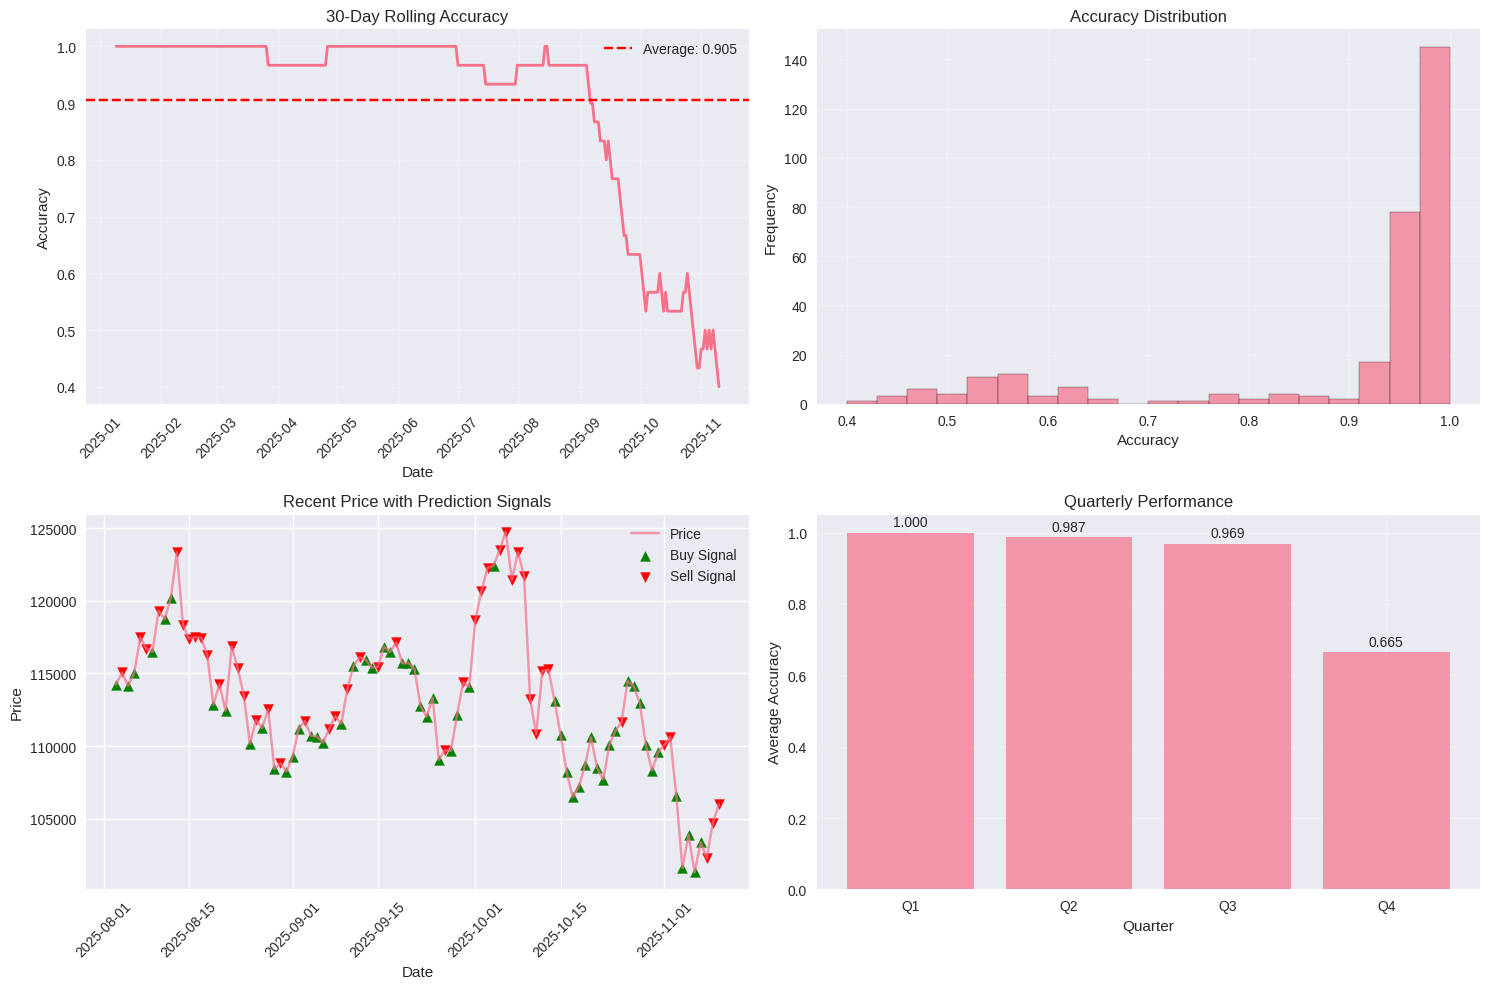


📈 MONITORING SUMMARY:
   Current Rolling Accuracy: 0.400
   Average Rolling Accuracy: 0.905
   Accuracy Std Dev: 0.165
   Best Rolling Accuracy: 1.000
   Worst Rolling Accuracy: 0.400
🚨 ALERT: Model performance has dropped significantly!


In [ ]:
def create_model_monitoring(historical_data, model, feature_columns, scaler):
    """
    Create a model performance monitoring system
    """
    print(f"\n📊 MODEL PERFORMANCE MONITORING")
    print("="*60)

    # Calculate rolling accuracy
    window_size = 30
    rolling_accuracies = []
    dates = []

    for i in range(window_size, len(historical_data)):
        # Get data for this window
        window_data = historical_data.iloc[i-window_size:i].copy() # Use .copy() to avoid SettingWithCopyWarning

        # Prepare features and target
        X_window = window_data[feature_columns]
        y_window = window_data['target_direction']

        # Scale and predict
        X_scaled = scaler.transform(X_window)
        predictions = model.predict(X_scaled)

        # Calculate accuracy
        accuracy = accuracy_score(y_window, predictions)
        rolling_accuracies.append(accuracy)
        dates.append(historical_data['date'].iloc[i] if 'date' in historical_data.columns else i)

    # Create monitoring dashboard
    plt.figure(figsize=(15, 10))

    # Plot 1: Rolling Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(dates, rolling_accuracies, linewidth=2)
    plt.axhline(y=np.mean(rolling_accuracies), color='r', linestyle='--',
                label=f'Average: {np.mean(rolling_accuracies):.3f}')
    plt.title('30-Day Rolling Accuracy')
    plt.xlabel('Date')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # Plot 2: Accuracy Distribution
    plt.subplot(2, 2, 2)
    plt.hist(rolling_accuracies, bins=20, alpha=0.7, edgecolor='black')
    plt.title('Accuracy Distribution')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    # Plot 3: Price with prediction signals
    plt.subplot(2, 2, 3)
    if 'date' in historical_data.columns and 'close' in historical_data.columns:
        # Get recent predictions
        recent_data = historical_data.iloc[-100:].copy() # Use .copy()
        X_recent = recent_data[feature_columns]
        X_recent_scaled = scaler.transform(X_recent)
        recent_predictions = model.predict(X_recent_scaled)

        plt.plot(recent_data['date'], recent_data['close'], label='Price', alpha=0.7)

        # Plot buy signals
        buy_signals = recent_data[recent_predictions == 1]
        plt.scatter(buy_signals['date'], buy_signals['close'],
                   color='green', marker='^', s=50, label='Buy Signal')

        # Plot sell signals
        sell_signals = recent_data[recent_predictions == 0]
        plt.scatter(sell_signals['date'], sell_signals['close'],
                   color='red', marker='v', s=50, label='Sell Signal')

        plt.title('Recent Price with Prediction Signals')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.xticks(rotation=45)

    # Plot 4: Performance metrics over time
    plt.subplot(2, 2, 4)
    quarterly_performance = []
    quarters = []

    # Simulate quarterly performance (you can adjust this)
    for quarter in range(4):
        start_idx = quarter * len(rolling_accuracies) // 4
        end_idx = (quarter + 1) * len(rolling_accuracies) // 4
        quarter_accuracy = np.mean(rolling_accuracies[start_idx:end_idx])
        quarterly_performance.append(quarter_accuracy)
        quarters.append(f'Q{quarter+1}')

    plt.bar(quarters, quarterly_performance, alpha=0.7)
    plt.title('Quarterly Performance')
    plt.xlabel('Quarter')
    plt.ylabel('Average Accuracy')
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for i, v in enumerate(quarterly_performance):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print monitoring summary
    print("\n📈 MONITORING SUMMARY:")
    print(f"   Current Rolling Accuracy: {rolling_accuracies[-1]:.3f}")
    print(f"   Average Rolling Accuracy: {np.mean(rolling_accuracies):.3f}")
    print(f"   Accuracy Std Dev: {np.std(rolling_accuracies):.3f}")
    print(f"   Best Rolling Accuracy: {np.max(rolling_accuracies):.3f}")
    print(f"   Worst Rolling Accuracy: {np.min(rolling_accuracies):.3f}")

    # Alert if performance drops significantly
    if rolling_accuracies[-1] < np.mean(rolling_accuracies) - 2*np.std(rolling_accuracies):
        print("🚨 ALERT: Model performance has dropped significantly!")

    return rolling_accuracies

# Ensure btc_data has the target_direction column before calling create_model_monitoring
if 'target_direction' not in btc_data.columns:
    print("Adding 'target_direction' column to btc_data...")
    btc_data = create_target_variable(btc_data)

# Create monitoring dashboard
rolling_accuracies = create_model_monitoring(btc_data, improved_model, feature_columns, scaler)

CREATING A STREAMLIT BASED UI AND DEPLOYMENT STAGE

In [ ]:

# Set page configuration
st.set_page_config(
    page_title="Crypto Price Predictor",
    page_icon="🚀",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS for better styling
st.markdown("""
<style>
    .main-header {
        font-size: 3rem;
        color: #1f77b4;
        text-align: center;
        margin-bottom: 2rem;
    }
    .prediction-card {
        padding: 2rem;
        border-radius: 10px;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        margin: 1rem 0;
        border-left: 5px solid;
    }
    .bullish {
        background: linear-gradient(135deg, #d4edda, #c3e6cb);
        border-left-color: #28a745;
    }
    .bearish {
        background: linear-gradient(135deg, #f8d7da, #f5c6cb);
        border-left-color: #dc3545;
    }
    .metric-card {
        background-color: #f8f9fa;
        padding: 1rem;
        border-radius: 10px;
        text-align: center;
        margin: 0.5rem;
        border: 1px solid #dee2e6;
    }
    .feature-card {
        background: white;
        padding: 1rem;
        border-radius: 8px;
        margin: 0.5rem 0;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
    }
</style>
""", unsafe_allow_html=True)

class CryptoPredictor:
    def __init__(self):
        self.model = None
        self.scaler = None
        self.feature_columns = None
        self.load_model()

    def load_model(self):
        """Load the trained model and scaler"""
        try:
            # Try to load your trained model
            model_data = joblib.load('crypto_model.pkl')
            self.model = model_data['model']
            self.scaler = model_data['scaler']
            self.feature_columns = model_data['features']
            return True
        except:
            # If model file doesn't exist, use demo mode
            st.sidebar.warning("⚠️ Model file not found. Using demo mode.")
            return False

    def get_current_data(self, crypto_symbol='BTC-USD', period='3mo'):
        """Get current cryptocurrency data"""
        try:
            with st.spinner(f'Fetching {crypto_symbol} data...'):
                data = yf.download(crypto_symbol, period=period, progress=False)
                data = data.reset_index()
                if 'Date' in data.columns:
                    data.columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
                return data
        except Exception as e:
            st.error(f"Error fetching data: {e}")
            return None

    def create_features(self, data):
        """Create technical features for prediction"""
        df = data.copy()

        # Price-based features
        df['price_change'] = df['close'].pct_change()
        df['high_low_ratio'] = df['high'] / df['low']

        # Moving averages
        df['sma_7'] = df['close'].rolling(7).mean()
        df['sma_30'] = df['close'].rolling(30).mean()
        df['sma_90'] = df['close'].rolling(90).mean()

        # Moving average ratios
        df['sma_7_ratio'] = df['close'] / df['sma_7']
        df['sma_30_ratio'] = df['close'] / df['sma_30']

        # Volatility
        df['volatility_7'] = df['price_change'].rolling(7).std()
        df['volatility_30'] = df['price_change'].rolling(30).std()

        # Volume indicators
        df['volume_sma'] = df['volume'].rolling(10).mean()
        df['volume_ratio'] = df['volume'] / df['volume_sma']

        # RSI
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))

        # Fill NaN values
        df = df.ffill().bfill()

        return df

    def predict(self, data):
        """Make prediction using the trained model or demo mode"""
        if self.model is None:
            return self.demo_prediction(data)

        try:
            # Create features
            featured_data = self.create_features(data)

            # Ensure we have all required features
            missing_features = set(self.feature_columns) - set(featured_data.columns)
            if missing_features:
                st.warning(f"Missing features: {missing_features}. Using demo mode.")
                return self.demo_prediction(data)

            latest_data = featured_data[self.feature_columns].iloc[-1:].fillna(0)

            # Scale features and predict
            scaled_data = self.scaler.transform(latest_data)
            prediction = self.model.predict(scaled_data)[0]

            if hasattr(self.model, 'predict_proba'):
                probability = self.model.predict_proba(scaled_data)[0]
                confidence = max(probability)
            else:
                probability = [0.5, 0.5]  # Default probabilities
                confidence = 0.6

            return {
                'prediction': prediction,
                'probability': probability,
                'confidence': confidence,
                'signal': 'BUY' if prediction == 1 else 'SELL',
                'demo': False
            }
        except Exception as e:
            st.error(f"Prediction error: {e}")
            return self.demo_prediction(data)

    def demo_prediction(self, data):
        """Demo prediction when model is not available"""
        # Simple logic based on recent price movement
        recent_trend = data['close'].iloc[-1] > data['close'].iloc[-5]
        confidence = 0.65  # Fixed confidence for demo

        return {
            'prediction': 1 if recent_trend else 0,
            'probability': [1-confidence, confidence] if recent_trend else [confidence, 1-confidence],
            'confidence': confidence,
            'signal': 'BUY' if recent_trend else 'SELL',
            'demo': True
        }

    def get_trading_recommendation(self, prediction_result):
        """Generate trading recommendation based on prediction"""
        signal = prediction_result['signal']
        confidence = prediction_result['confidence']

        if prediction_result.get('demo', False):
            base = "DEMO: "
        else:
            base = ""

        if signal == 'BUY':
            if confidence > 0.7:
                return f"{base}STRONG BUY SIGNAL 🚀"
            elif confidence > 0.6:
                return f"{base}BUY SIGNAL 📈"
            else:
                return f"{base}WEAK BUY ↗️"
        else:
            if confidence > 0.7:
                return f"{base}STRONG SELL SIGNAL 🚨"
            elif confidence > 0.6:
                return f"{base}SELL SIGNAL 📉"
            else:
                return f"{base}WEAK SELL ↘️"

def main():
    # Initialize predictor
    predictor = CryptoPredictor()

    # Header
    st.markdown('<h1 class="main-header">🚀 AI Crypto Price Predictor</h1>', unsafe_allow_html=True)

    # Sidebar
    st.sidebar.title("🎯 Configuration")

    crypto_options = {
        'Bitcoin (BTC)': 'BTC-USD',
        'Ethereum (ETH)': 'ETH-USD',
        'Cardano (ADA)': 'ADA-USD',
        'Solana (SOL)': 'SOL-USD',
        'Dogecoin (DOGE)': 'DOGE-USD',
        'Binance Coin (BNB)': 'BNB-USD',
        'XRP (XRP)': 'XRP-USD',
        'Polkadot (DOT)': 'DOT-USD'
    }

    selected_crypto = st.sidebar.selectbox(
        "Select Cryptocurrency:",
        list(crypto_options.keys()),
        index=0
    )

    crypto_symbol = crypto_options[selected_crypto]

    time_period = st.sidebar.selectbox(
        "Time Period:",
        ['1mo', '3mo', '6mo', '1y'],
        index=1
    )

    # Main content
    col1, col2 = st.columns([2, 1])

    with col1:
        st.subheader(f"📊 {selected_crypto} Market Analysis")

        # Get current data
        data = predictor.get_current_data(crypto_symbol, time_period)

        if data is not None:
            # Display current price metrics
            current_price = data['close'].iloc[-1]
            prev_price = data['close'].iloc[-2]
            price_change = ((current_price - prev_price) / prev_price) * 100
            price_change_color = "normal" if price_change >= 0 else "inverse"

            col1a, col1b, col1c = st.columns(3)
            with col1a:
                st.metric(
                    label="Current Price",
                    value=f"${current_price:,.2f}",
                    delta=f"{price_change:+.2f}%"
                )
            with col1b:
                st.metric(
                    label="24h High",
                    value=f"${data['high'].iloc[-1]:,.2f}"
                )
            with col1c:
                st.metric(
                    label="24h Low",
                    value=f"${data['low'].iloc[-1]:,.2f}"
                )

            # Price chart
            st.subheader("Price Chart")
            fig, ax = plt.subplots(figsize=(10, 4))
            ax.plot(data['date'], data['close'], linewidth=2, color='#1f77b4', alpha=0.8)
            ax.fill_between(data['date'], data['close'], alpha=0.3, color='#1f77b4')
            ax.set_title(f'{selected_crypto} Price Trend', fontweight='bold', fontsize=14)
            ax.set_ylabel('Price (USD)', fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
            plt.tight_layout()
            st.pyplot(fig)

            # Technical indicators
            st.subheader("📈 Technical Indicators")
            featured_data = predictor.create_features(data)
            latest_features = featured_data.iloc[-1]

            tech_col1, tech_col2, tech_col3, tech_col4 = st.columns(4)
            with tech_col1:
                rsi_value = latest_features.get('rsi', 50)
                rsi_color = "red" if rsi_value > 70 else "green" if rsi_value < 30 else "orange"
                st.metric("RSI (14)", f"{rsi_value:.1f}", delta_color="off")
            with tech_col2:
                st.metric("7-Day Volatility", f"{latest_features.get('volatility_7', 0):.3f}")
            with tech_col3:
                st.metric("Price/7-SMA", f"{latest_features.get('sma_7_ratio', 1):.3f}")
            with tech_col4:
                st.metric("Volume Ratio", f"{latest_features.get('volume_ratio', 1):.2f}")

    with col2:
        st.subheader("🤖 AI Prediction")

        if data is not None:
            # Make prediction
            with st.spinner('Analyzing market patterns...'):
                prediction_result = predictor.predict(data)

            # Display prediction card
            is_bullish = prediction_result['prediction'] == 1
            confidence = prediction_result['confidence']

            card_class = "bullish" if is_bullish else "bearish"
            emoji = "🚀" if is_bullish else "📉"
            signal_text = "BULLISH" if is_bullish else "BEARISH"
            color = "#155724" if is_bullish else "#721c24"

            st.markdown(f"""
            <div class="prediction-card {card_class}">
                <h2 style="margin:0; color: {color};">
                    {emoji} {signal_text}
                </h2>
                <p style="font-size: 1.5rem; margin: 0.5rem 0; font-weight: bold;">
                    Confidence: <span style="color: {color};">{confidence:.1%}</span>
                </p>
                <p style="font-size: 1.2rem; margin: 0.5rem 0;">
                    Signal: <strong>{prediction_result['signal']}</strong>
                </p>
            </div>
            """, unsafe_allow_html=True)

            # Trading recommendation
            recommendation = predictor.get_trading_recommendation(prediction_result)
            st.info(f"**💡 Recommendation:** {recommendation}")

            # Probability breakdown
            if 'probability' in prediction_result:
                prob_bullish = prediction_result['probability'][1] * 100
                prob_bearish = prediction_result['probability'][0] * 100

                st.subheader("Probability Breakdown")

                prob_col1, prob_col2 = st.columns(2)
                with prob_col1:
                    st.metric("📈 Up Probability", f"{prob_bullish:.1f}%")
                with prob_col2:
                    st.metric("📉 Down Probability", f"{prob_bearish:.1f}%")

                # Probability bar chart
                fig_prob, ax_prob = plt.subplots(figsize=(8, 3))
                bars = ax_prob.bar(['Down', 'Up'], [prob_bearish, prob_bullish],
                                 color=['#dc3545', '#28a745'], alpha=0.7)
                ax_prob.set_ylabel('Probability (%)')
                ax_prob.set_ylim(0, 100)
                ax_prob.grid(True, alpha=0.3, axis='y')

                # Add value labels on bars
                for bar in bars:
                    height = bar.get_height()
                    ax_prob.text(bar.get_x() + bar.get_width()/2., height + 1,
                               f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

                plt.tight_layout()
                st.pyplot(fig_prob)

            if prediction_result.get('demo', False):
                st.warning("""
                **ℹ️ Demo Mode Active**
                - Using simulated predictions based on price trends
                - Train and save your model for AI predictions
                - Current logic: Bullish if recent price trend is positive
                """)

    # Additional sections
    st.markdown("---")

    # Market Insights Section
    st.subheader("🔍 Market Insights & Analysis")

    if data is not None:
        insight_col1, insight_col2, insight_col3 = st.columns(3)

        with insight_col1:
            st.markdown("""
            <div class="metric-card">
                <h3>📊 Trend Analysis</h3>
                <p>Current market direction and momentum indicators</p>
            </div>
            """, unsafe_allow_html=True)

            # Simple trend analysis
            price_5d_ago = data['close'].iloc[-5]
            price_trend = (current_price - price_5d_ago) / price_5d_ago * 100
            st.metric("5-Day Trend", f"{price_trend:+.2f}%")

        with insight_col2:
            st.markdown("""
            <div class="metric-card">
                <h3>⚡ Volatility</h3>
                <p>Market stability and risk assessment</p>
            </div>
            """, unsafe_allow_html=True)

            volatility_30d = data['close'].pct_change().std() * 100
            st.metric("30-Day Volatility", f"{volatility_30d:.2f}%")

        with insight_col3:
            st.markdown("""
            <div class="metric-card">
                <h3>📈 Support/Resistance</h3>
                <p>Key price levels to watch</p>
            </div>
            """, unsafe_allow_html=True)

            resistance = data['high'].tail(20).max()
            support = data['low'].tail(20).min()
            st.metric("Resistance", f"${resistance:,.2f}")
            st.metric("Support", f"${support:,.2f}")

    # Risk Management Section
    st.markdown("---")
    st.subheader("🛡️ Risk Management")

    risk_col1, risk_col2, risk_col3 = st.columns(3)

    with risk_col1:
        st.markdown("""
        <div class="feature-card">
            <h4>🎯 Position Sizing</h4>
            <p>Based on prediction confidence:</p>
            <ul>
                <li>High confidence (>70%): 2-3% of portfolio</li>
                <li>Medium confidence (60-70%): 1-2% of portfolio</li>
                <li>Low confidence (<60%): 0.5-1% of portfolio</li>
            </ul>
        </div>
        """, unsafe_allow_html=True)

    with risk_col2:
        st.markdown("""
        <div class="feature-card">
            <h4>📉 Stop-Loss Strategy</h4>
            <p>Recommended stop-loss levels:</p>
            <ul>
                <li>Bullish trades: 3-5% below entry</li>
                <li>Bearish trades: 3-5% above entry</li>
                <li>Adjust based on volatility</li>
            </ul>
        </div>
        """, unsafe_allow_html=True)

    with risk_col3:
        st.markdown("""
        <div class="feature-card">
            <h4>⚖️ Portfolio Allocation</h4>
            <p>Smart allocation tips:</p>
            <ul>
                <li>Max 20% in crypto total</li>
                <li>Diversify across 3-5 coins</li>
                <li>Rebalance monthly</li>
            </ul>
        </div>
        """, unsafe_allow_html=True)

    # Footer
    st.markdown("---")
    st.markdown("""
    <div style="text-align: center; color: #666; margin-top: 2rem;">
        <p>Built with ❤️ using Streamlit | 🤖 AI-Powered Crypto Predictions</p>
        <p><small>Disclaimer: This is for educational purposes. Always do your own research and consider consulting with a qualified financial advisor before making any investment decisions.</small></p>
    </div>
    """, unsafe_allow_html=True)

    # Refresh button in sidebar
    st.sidebar.markdown("---")
    if st.sidebar.button("🔄 Refresh Data & Prediction"):
        st.rerun()

    # Model status in sidebar
    st.sidebar.markdown("---")
    st.sidebar.subheader("Model Status")
    if predictor.model is not None:
        st.sidebar.success("✅ AI Model Loaded")
        st.sidebar.write(f"Features: {len(predictor.feature_columns)}")
    else:
        st.sidebar.warning("⚠️ Demo Mode")
        st.sidebar.write("Using trend-based predictions")

if __name__ == "__main__":
    main()

2025-11-11 18:31:33.115 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 18:31:33.116 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 18:31:33.117 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 18:31:33.120 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 18:31:33.126 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 18:31:33.128 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 18:31:33.129 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 18:31:33.130 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar